# Exploratory Data Analysis

This notebook runs through a series of exploratory data analyses to assess the integrity and quality of the raw data.

## Installations

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import json
from dataprofiler import Data, Profiler
from functools import reduce

# Set display of images in the notebook
%matplotlib notebook

# imputation libraries
from sklearn.impute import SimpleImputer, KNNImputer

# standardize variables
from sklearn.preprocessing import StandardScaler, MinMaxScaler 

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# check versions
print(f'pandas version: {pd.__version__}')
print(f'numpy version: {np.__version__}')
print(f'seaborn version: {sns.__version__}')

pandas version: 1.3.2
numpy version: 1.21.2
seaborn version: 0.12.2


## Basic exploratory data approach

In [3]:
# Read data from csv and set data types (dtype), except the first column -'calldate'- which will be parsed later.
df = pd.read_csv("../data/raw_data.csv", sep=',', engine='python')

In [4]:
# Inspect the dataframe
print(df.shape)
print(df.info())

(10000, 41)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x0      9989 non-null   float64
 1   x1      9986 non-null   float64
 2   x2      9990 non-null   float64
 3   x3      9988 non-null   float64
 4   x4      9991 non-null   float64
 5   x5      9992 non-null   float64
 6   x6      9991 non-null   float64
 7   x7      9985 non-null   float64
 8   x8      9991 non-null   float64
 9   x9      9989 non-null   float64
 10  x10     9993 non-null   float64
 11  x11     9982 non-null   float64
 12  x12     9987 non-null   float64
 13  x13     9987 non-null   float64
 14  x14     9992 non-null   float64
 15  x15     9994 non-null   float64
 16  x16     9992 non-null   float64
 17  x17     9988 non-null   float64
 18  x18     9988 non-null   float64
 19  x19     9990 non-null   float64
 20  x20     9995 non-null   float64
 21  x21     9995 non-null   

In [5]:
# If necessary, convert columns to str without spaces in lower case
df.columns = df.columns.str.replace('\s+', '_').str.lower()

#### Apply manual functions for data quality checks

In [6]:
### analyze null values
def nullvalues(d):
    ''' Number of null values for each feature and 
        percentage of null values for each feature'''
    print("{:10s}|{:10s}|{:10s}".format("Feature",
                                        "Null values",
                                        "Null Values as a Proportion of Total"))
    print("="*100)
    for col in d.columns:
        null_values = d[col].isnull().sum(axis=0)
        null_values_pct = d[col].isnull().sum(axis=0)/len(d)*100
        print("{:10s}|{:10d}\t|{:10f}".format(str(col),
                                             null_values,
                                             null_values_pct))

### analyze cardinality
def cardinality(data):
    ''' Check number of unique values of variables
        not accounting for null values '''
    print("{:15s}\t| {:10s}\t| {:10s}".format("Feature",
                                              "Distinct Values",
                                              "Distinct Values as a Proportion of Total"))
    print("="*100)
    for col in data.columns[:]:
        unique_values = len(np.unique(data[col].ffill()))
        unique_values_pct = len(np.unique(data[col].ffill()))/len(data) 
        print("{:15s}\t| {:10d}\t\t| {:10f}".format(str(col),
                                                   unique_values,
                                                   unique_values_pct))

### analyze duplicates
def rowduplication(data):
    ''' Assess the number and percent of duplicates for entire rows in dataset '''
    data_dedup = data.drop_duplicates(keep='first')
    data_duplicates = data[data.duplicated(subset=None, keep='first')]
    
    print('Shape of de-duplicated dataset', data_dedup.shape)
    print('Number of duplicates:', len(data) - len(data_dedup))
    print('Confirm number of duplicates:', len(data_duplicates))

def duplicationanalyzer(data):
    ''' Assess the number and percentage of duplicates 
        for each variable in the dataset'''
    variable = pd.Series(np.nan)
    
    for var in data:
        ''' Output the number of duplicates and proportion of duplicates '''
        variable = data[var]
        
        # construct variable dataframe less duplicates
        variable_dedup = variable.drop_duplicates(keep='first')
        
        #print the number of duplicates
        duplicates=data[data[var].duplicated(keep=False)]
        print(var)
        print('Number of duplicates: ', len(duplicates))
        
        #print the percentage of duplicates
        percentage = "{0:.4f}".format(len(duplicates)/len(data))
        print('Percentage of duplicates: ', percentage)

In [7]:
nullvalues(d=df)

Feature   |Null values|Null Values as a Proportion of Total
x0        |        11	|  0.110000
x1        |        14	|  0.140000
x2        |        10	|  0.100000
x3        |        12	|  0.120000
x4        |         9	|  0.090000
x5        |         8	|  0.080000
x6        |         9	|  0.090000
x7        |        15	|  0.150000
x8        |         9	|  0.090000
x9        |        11	|  0.110000
x10       |         7	|  0.070000
x11       |        18	|  0.180000
x12       |        13	|  0.130000
x13       |        13	|  0.130000
x14       |         8	|  0.080000
x15       |         6	|  0.060000
x16       |         8	|  0.080000
x17       |        12	|  0.120000
x18       |        12	|  0.120000
x19       |        10	|  0.100000
x20       |         5	|  0.050000
x21       |         5	|  0.050000
x22       |         7	|  0.070000
x23       |        11	|  0.110000
x24       |        10	|  0.100000
x25       |        14	|  0.140000
x26       |        12	|  0.120000
x27       |        11	

In [8]:
cardinality(data=df)

Feature        	| Distinct Values	| Distinct Values as a Proportion of Total
x0             	|       9989		|   0.998900
x1             	|       9986		|   0.998600
x2             	|       9990		|   0.999000
x3             	|       9988		|   0.998800
x4             	|       9991		|   0.999100
x5             	|       9992		|   0.999200
x6             	|       9991		|   0.999100
x7             	|       9985		|   0.998500
x8             	|       9991		|   0.999100
x9             	|       9989		|   0.998900
x10            	|       9993		|   0.999300
x11            	|       9982		|   0.998200
x12            	|       9987		|   0.998700
x13            	|       9987		|   0.998700
x14            	|       9992		|   0.999200
x15            	|       9994		|   0.999400
x16            	|       9992		|   0.999200
x17            	|       9988		|   0.998800
x18            	|       9988		|   0.998800
x19            	|       9990		|   0.999000
x20            	|       9995		|   0.999500
x21            	|   

In [9]:
rowduplication(data=df)

Shape of de-duplicated dataset (10000, 41)
Number of duplicates: 0
Confirm number of duplicates: 0


In [10]:
duplicationanalyzer(data=df)

x0
Number of duplicates:  11
Percentage of duplicates:  0.0011
x1
Number of duplicates:  14
Percentage of duplicates:  0.0014
x2
Number of duplicates:  10
Percentage of duplicates:  0.0010
x3
Number of duplicates:  12
Percentage of duplicates:  0.0012
x4
Number of duplicates:  9
Percentage of duplicates:  0.0009
x5
Number of duplicates:  8
Percentage of duplicates:  0.0008
x6
Number of duplicates:  9
Percentage of duplicates:  0.0009
x7
Number of duplicates:  15
Percentage of duplicates:  0.0015
x8
Number of duplicates:  9
Percentage of duplicates:  0.0009
x9
Number of duplicates:  11
Percentage of duplicates:  0.0011
x10
Number of duplicates:  7
Percentage of duplicates:  0.0007
x11
Number of duplicates:  18
Percentage of duplicates:  0.0018
x12
Number of duplicates:  13
Percentage of duplicates:  0.0013
x13
Number of duplicates:  13
Percentage of duplicates:  0.0013
x14
Number of duplicates:  8
Percentage of duplicates:  0.0008
x15
Number of duplicates:  6
Percentage of duplicates:  

#### Explore summary statistics

In [11]:
# define functions for summary statistics on categorical and numeric variables

def catvardistribution(data, var, title):
    ''' Examine value counts and countplots'''
    %matplotlib inline
    fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
    print(data[var].value_counts(dropna=False))
    sns.set(style='darkgrid')
    ax = sns.countplot(x=data[var], data=data)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_title(title)
    plt.show()

def summarystats(data, var, titleplot, n_bins):
    ''' Print summary statistics, show histogram and boxplot '''
    %matplotlib inline
    print(data[var].unique())
    print(data[var].describe())
    n_bins = n_bins
    fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
    plt.hist(data[var], bins=n_bins)
    plt.title(titleplot, loc='center', pad=None)
    plt.show()
#     sns.set(style='darkgrid')
#     ax = sns.boxplot(x=data[var])
#     print(ax)

def sidebysideboxplots(data, xvar, yvar, xtitle, ytitle):
    ''' Generate side-by-side boxplots'''
    %matplotlib inline
    ax = sns.boxplot(x=xvar, y=yvar, data=data)
    ax.set_xlabel(xtitle)
    ax.set_ylabel(ytitle)

def corrmap(data,figx, figy):
    '''Generate correlation heatmap'''
    %matplotlib inline
    var_corr = data.corr()
    var_corr = var_corr.round(3)
    # plot the heatmap and annotation on it
    fig, ax = plt.subplots(figsize=(figx,figy))         # Sample figsize
    sns.heatmap(var_corr, xticklabels=var_corr.columns, yticklabels=var_corr.columns, annot=True)

    # Fix axes
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show()
    
def binary_means(data, feature_group, y_col):
    ''' Show mean scores by feature category '''
    cols = feature_dict[feature_group]
    #cols = feat_eng
    for col in cols:
        print(col)
        print(data.groupby(y_col)[col].mean())
        print('')

Create a list of all float, int and string variables

In [12]:
# create list of float variables
float_vars = list()        
for x in df.columns:
    if df[x].dtypes == 'float64':
        float_vars.append(x)

# create list of int variables
int_vars = list()        
for x in df.columns:
    if df[x].dtypes == 'int':
        int_vars.append(x)

# create list of string variables
string_vars = list()        
for x in df.columns:
    if df[x].dtypes == 'str':
        string_vars.append(x)
        
print(float_vars)
print(int_vars)
print(string_vars) 

['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39']
['y']
[]


In [13]:
# save dictionary of feature lists
feature_dict = {'strings':string_vars, 'floats':float_vars, 'ints':int_vars}
# feature_dict = {'floats':float_vars}
feature_dict

{'strings': [],
 'floats': ['x0',
  'x1',
  'x2',
  'x3',
  'x4',
  'x5',
  'x6',
  'x7',
  'x8',
  'x9',
  'x10',
  'x11',
  'x12',
  'x13',
  'x14',
  'x15',
  'x16',
  'x17',
  'x18',
  'x19',
  'x20',
  'x21',
  'x22',
  'x23',
  'x24',
  'x25',
  'x26',
  'x27',
  'x28',
  'x29',
  'x30',
  'x31',
  'x32',
  'x33',
  'x34',
  'x35',
  'x36',
  'x37',
  'x38',
  'x39'],
 'ints': ['y']}

1    5000
0    5000
Name: y, dtype: int64


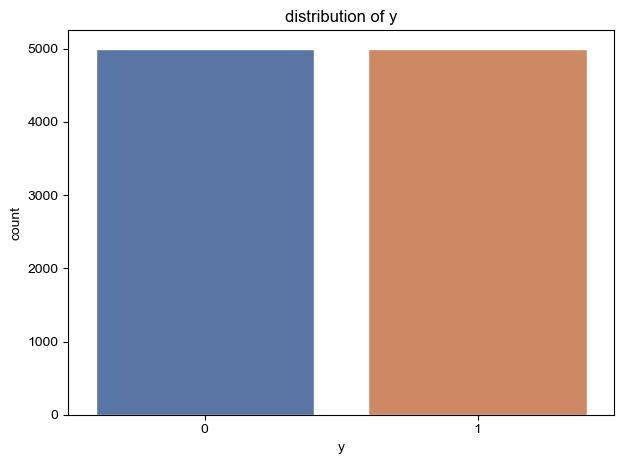

In [14]:
catvardistribution(data=df, var='y', title='distribution of y')

#### Run summary statistics on each variable

[ 1.56331156 -1.95217853  0.966699   ...  0.29324059  0.5822515
  1.91605876]
count    9989.000000
mean       -0.005189
std         0.986491
min        -3.607155
25%        -0.672573
50%        -0.006646
75%         0.649986
max         3.808301
Name: x0, dtype: float64


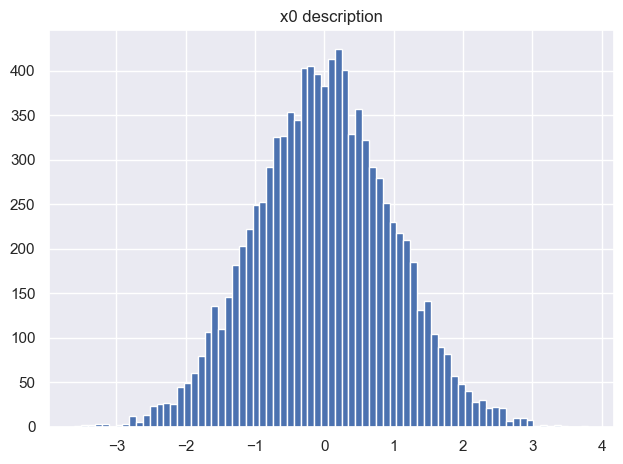

[-1.41745405  0.12701261 -0.47627632 ... -0.51010466 -0.00471088
 -0.38422039]
count    9986.000000
mean       -0.005445
std         0.991920
min        -3.443086
25%        -0.667908
50%        -0.013220
75%         0.652413
max         3.686834
Name: x1, dtype: float64


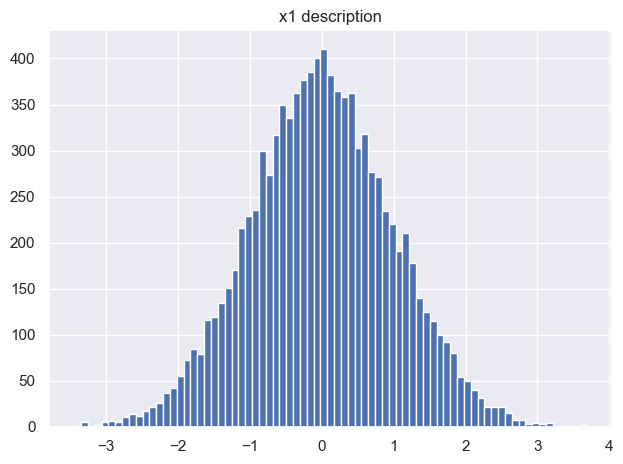

[-0.49021032  1.53829849  0.49171341 ...  0.83777624 -1.84531471
 -2.04546235]
count    9990.000000
mean       -0.014678
std         0.996166
min        -3.712265
25%        -0.698186
50%        -0.023411
75%         0.665618
max         3.470688
Name: x2, dtype: float64


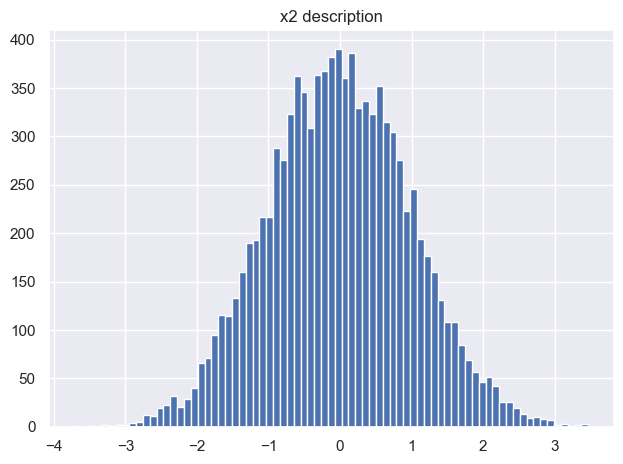

[-1.56868915  0.34690556  1.77852068 ... -0.19274573  0.59574029
  0.23597387]
count    9988.000000
mean       -0.004621
std         0.994909
min        -3.665978
25%        -0.668270
50%        -0.011911
75%         0.676139
max         3.670963
Name: x3, dtype: float64


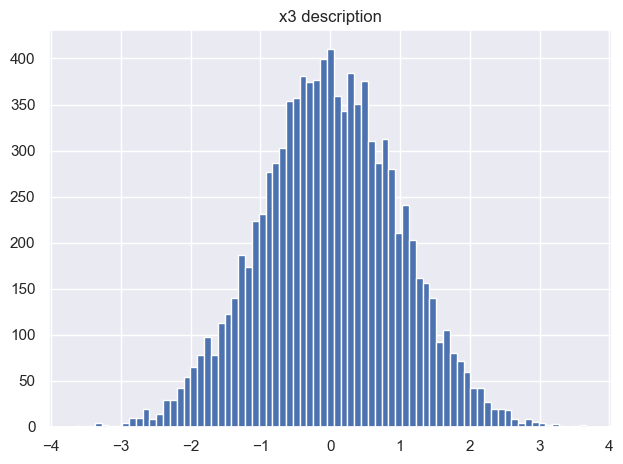

[ 0.36742095  1.18842391 -0.97724283 ... -0.17685229  0.55261497
  0.55447203]
count    9991.000000
mean        0.018562
std         1.005798
min        -3.992339
25%        -0.651645
50%         0.013732
75%         0.682619
max         3.491511
Name: x4, dtype: float64


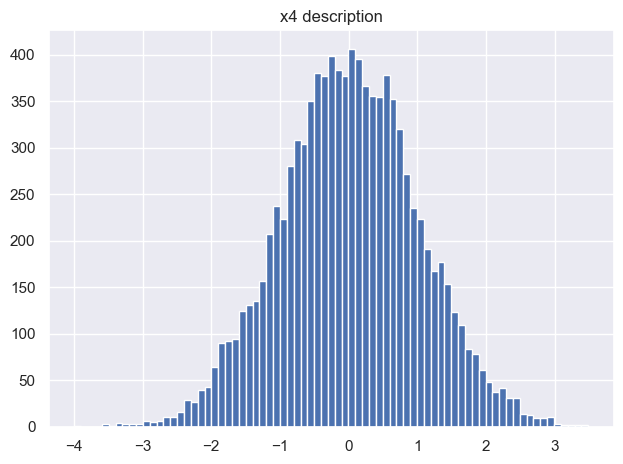

[ 0.07030344  0.81258326 -0.46530664 ... -0.63888336  0.72776655
 -0.41678003]
count    9992.000000
mean        0.000306
std         1.002771
min        -3.374208
25%        -0.690456
50%         0.008940
75%         0.672562
max         4.496129
Name: x5, dtype: float64


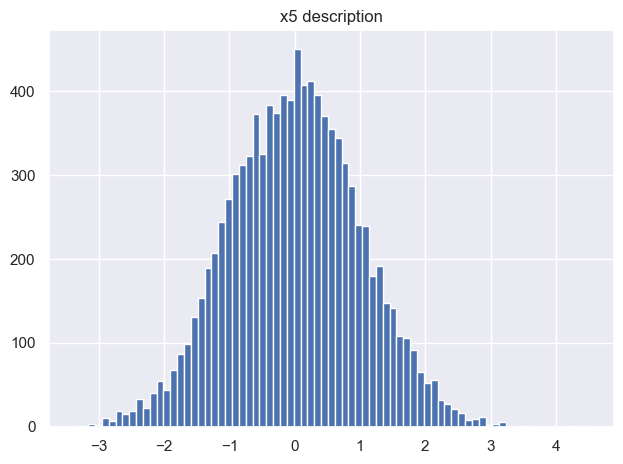

[-0.535064   -0.93155927 -1.0262942  ... -0.71561908  0.12115315
  1.01927733]
count    9991.000000
mean        0.000389
std         1.009328
min        -4.472915
25%        -0.685953
50%         0.010126
75%         0.672810
max         3.753948
Name: x6, dtype: float64


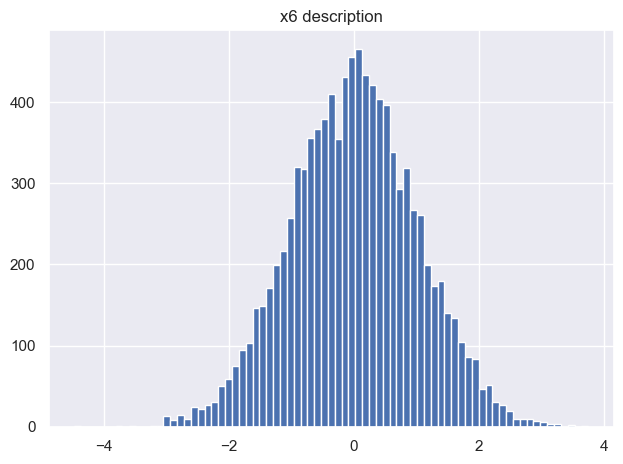

[ 0.16115388  0.81511449  0.52678694 ... -0.97308676 -1.21256305
  0.28058796]
count    9985.000000
mean       -0.004721
std         0.997614
min        -3.955288
25%        -0.686043
50%         0.009222
75%         0.678167
max         3.613226
Name: x7, dtype: float64


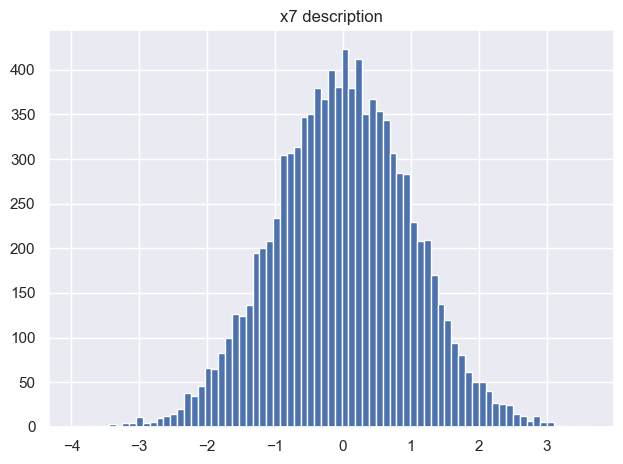

[ 0.13025494 -0.33113506 -0.42304758 ...  0.68016548  1.30993674
 -1.0082216 ]
count    9991.000000
mean        0.004683
std         0.996983
min        -3.419288
25%        -0.662617
50%         0.012949
75%         0.676527
max         3.619799
Name: x8, dtype: float64


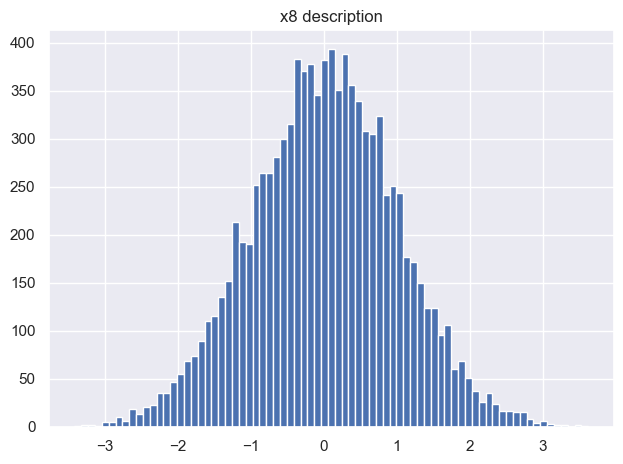

[ 0.75382275 -1.20211019  1.58442099 ...  2.1006561   0.89112865
 -0.85843339]
count    9989.000000
mean       -0.004302
std         1.006986
min        -4.007732
25%        -0.681302
50%        -0.011135
75%         0.675798
max         4.014372
Name: x9, dtype: float64


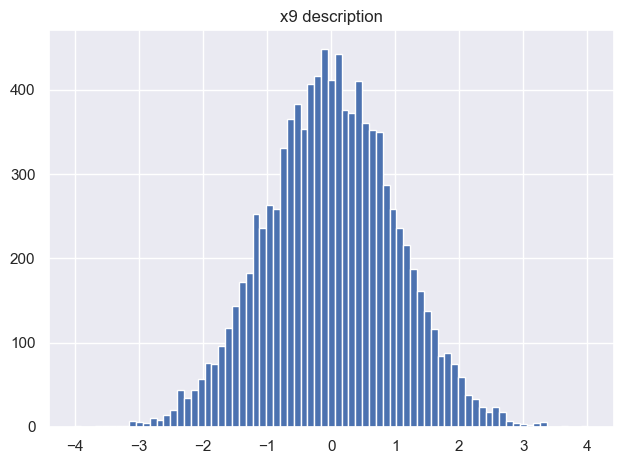

[ 1.53442659  0.61308431  1.57311709 ... -0.97488994 -1.59888419
 -1.56732691]
count    9993.000000
mean       -0.010664
std         0.998708
min        -4.580175
25%        -0.689191
50%        -0.007559
75%         0.663582
max         4.268941
Name: x10, dtype: float64


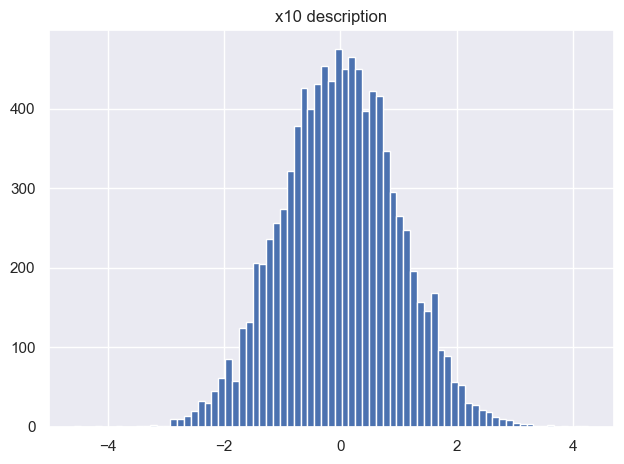

[ 0.40964743  0.96051881 -1.44757306 ...  2.27005968  0.05063622
 -1.0500852 ]
count    9982.000000
mean        0.020016
std         0.985009
min        -3.797071
25%        -0.646486
50%         0.009507
75%         0.683083
max         3.672656
Name: x11, dtype: float64


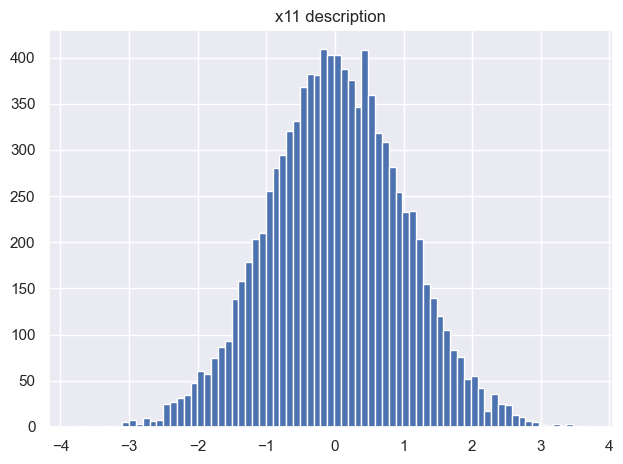

[ 0.83491938 -0.23674973  0.07713486 ... -0.23916023 -0.69539544
  0.65594171]
count    9987.000000
mean        0.005404
std         0.999770
min        -4.058818
25%        -0.670669
50%         0.009315
75%         0.680430
max         3.462487
Name: x12, dtype: float64


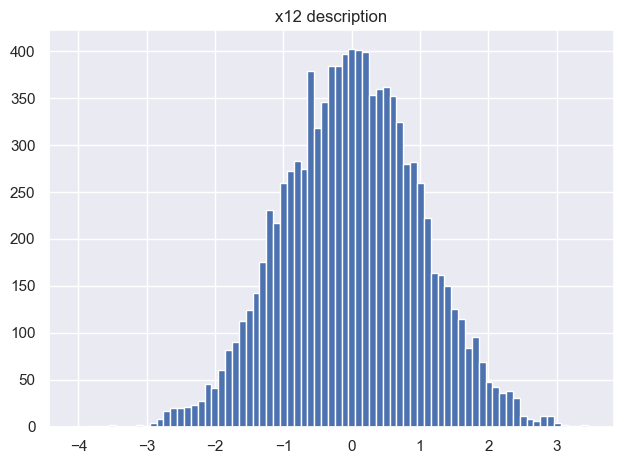

[ 1.29870877 -0.93676283 -0.41575323 ...  0.92994117 -1.10652315
  0.65104113]
count    9987.000000
mean       -0.000590
std         1.403341
min        -6.140022
25%        -1.011729
50%         0.191556
75%         1.098282
max         4.943139
Name: x13, dtype: float64


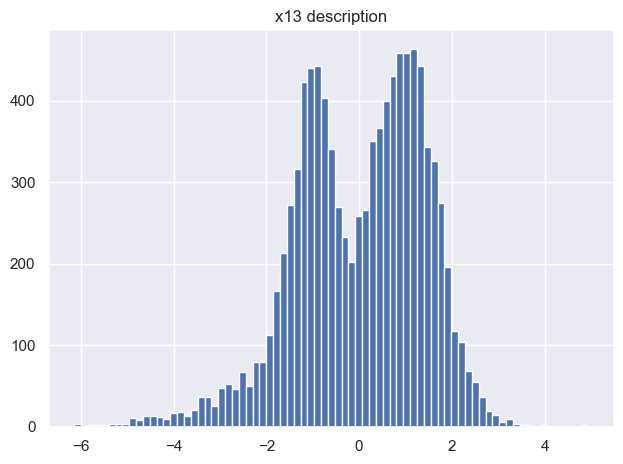

[ 0.05800927  0.21354268 -0.08672329 ...  0.5742933   0.54160233
  1.05116339]
count    9992.000000
mean        0.012635
std         1.007022
min        -3.782551
25%        -0.674652
50%         0.001036
75%         0.689497
max         3.990200
Name: x14, dtype: float64


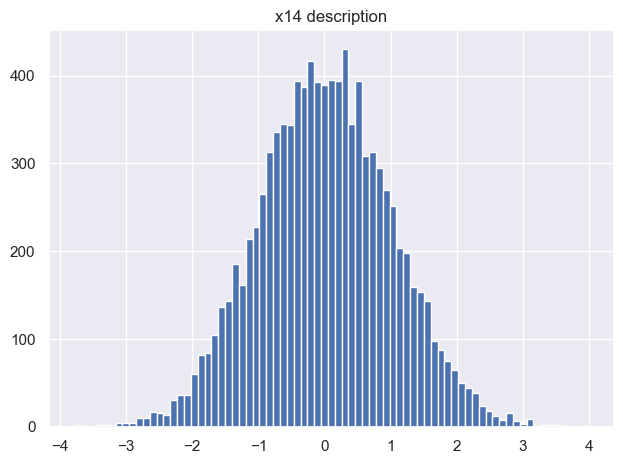

[ 0.54542221  0.37400327 -1.1083889  ...  0.85075083  1.12143456
 -0.48828966]
count    9994.000000
mean       -0.244892
std         1.248388
min        -4.848131
25%        -1.094819
50%        -0.165854
75%         0.665633
max         3.520093
Name: x15, dtype: float64


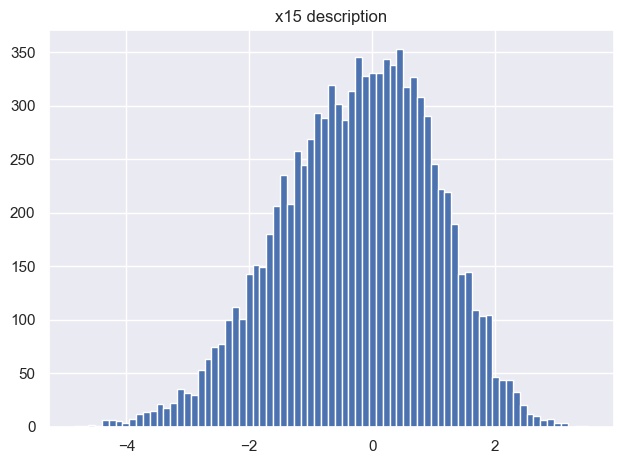

[ 0.478652    2.84390162 -0.33214393 ...  0.81166862 -1.97806824
  0.42315783]
count    9992.000000
mean       -0.004087
std         0.997482
min        -4.024865
25%        -0.677420
50%        -0.010806
75%         0.666076
max         3.501516
Name: x16, dtype: float64


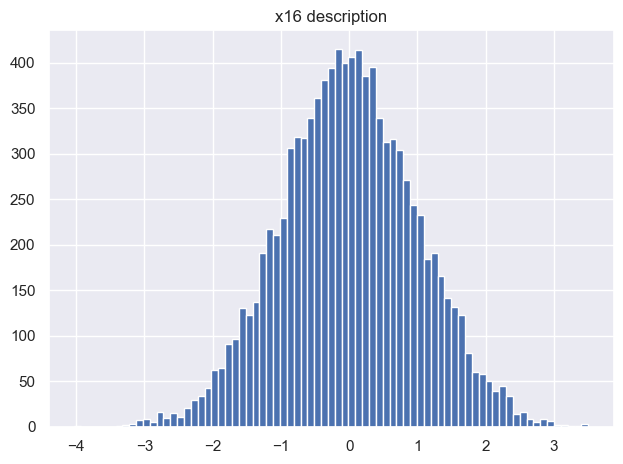

[-0.13564114 -0.50729077 -0.17393181 ... -1.7632811   0.75102083
 -0.71217301]
count    9988.000000
mean        0.006487
std         1.005302
min        -3.977414
25%        -0.668560
50%         0.001863
75%         0.678623
max         4.293922
Name: x17, dtype: float64


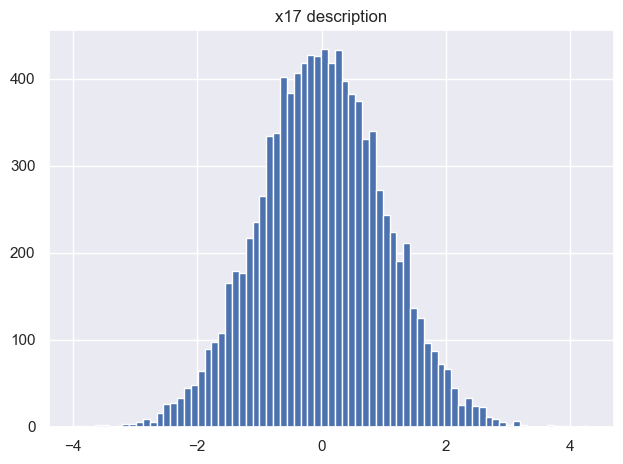

[-0.72882459 -0.97331861  0.64499662 ... -0.34987095 -0.12738611
 -1.47455637]
count    9988.000000
mean        0.005672
std         0.998769
min        -4.458664
25%        -0.665998
50%         0.000002
75%         0.670850
max         3.797440
Name: x18, dtype: float64


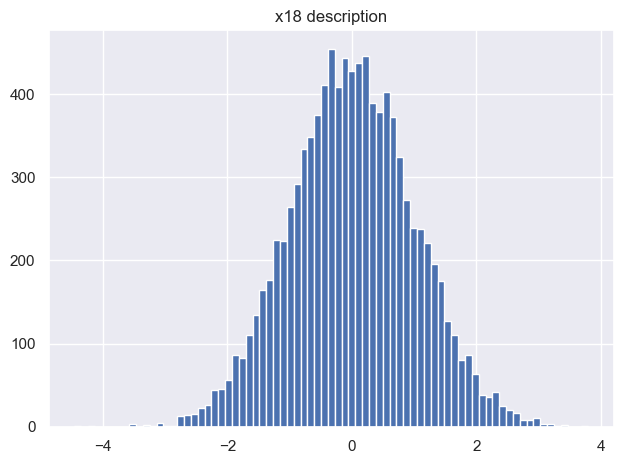

[-0.80149564 -0.59197644 -2.16173162 ...  0.78637611 -0.46217687
 -0.28794563]
count    9990.000000
mean       -0.008480
std         0.994118
min        -3.958827
25%        -0.680035
50%        -0.022887
75%         0.677673
max         4.093429
Name: x19, dtype: float64


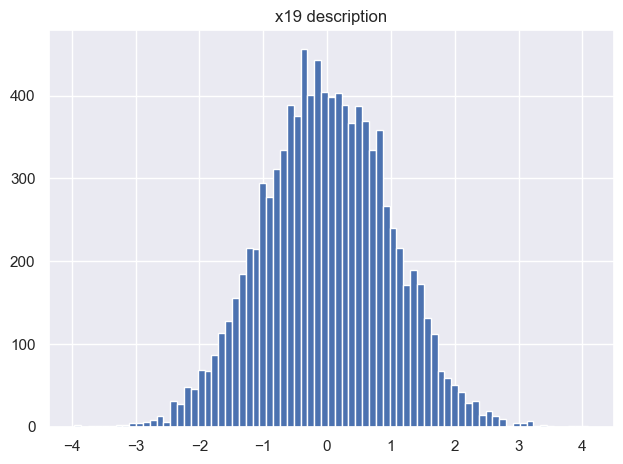

[-0.80521082 -0.49169984  1.07510426 ... -2.51027732 -1.31169896
 -0.76841828]
count    9995.000000
mean       -0.006530
std         1.317226
min        -4.247362
25%        -1.014342
50%        -0.033971
75%         1.010792
max         3.766584
Name: x20, dtype: float64


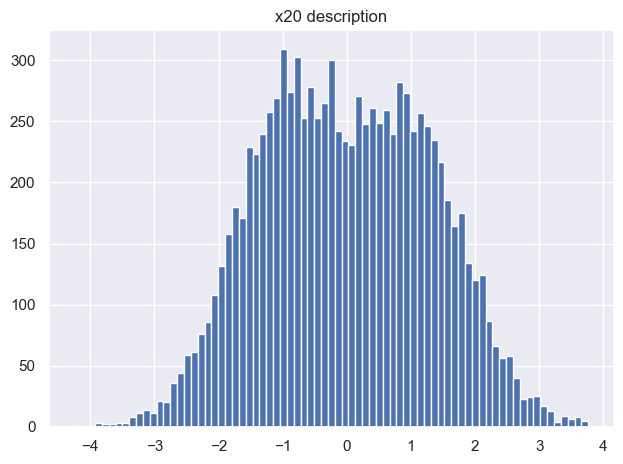

[ 0.09448542  0.29982979 -0.70987666 ... -0.0834389  -0.5497023
  0.26935203]
count    9995.000000
mean       -0.003586
std         0.997996
min        -3.942723
25%        -0.685260
50%        -0.004963
75%         0.671728
max         4.024593
Name: x21, dtype: float64


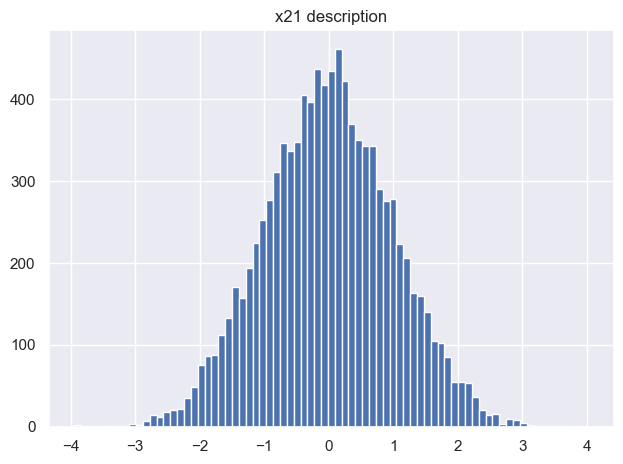

[ 0.46742139  0.5375868   0.93290792 ... -0.4474846   0.07106949
  0.46136641]
count    9993.000000
mean       -0.004454
std         0.996052
min        -4.066952
25%        -0.683464
50%         0.007980
75%         0.679702
max         3.402088
Name: x22, dtype: float64


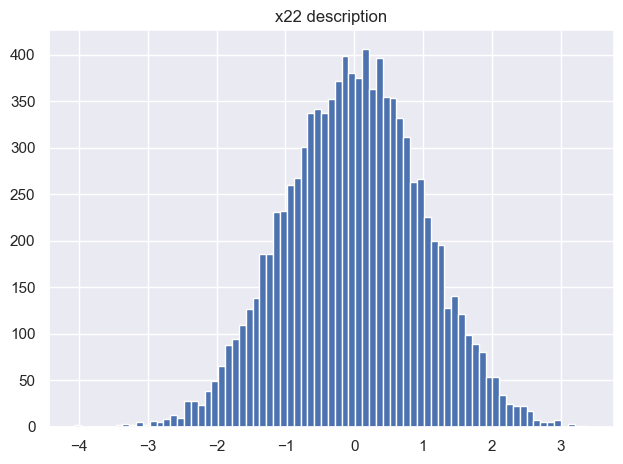

[ 0.18549756  0.16407272  0.17281239 ...  0.90942874 -0.28255895
 -1.0586624 ]
count    9989.000000
mean        0.009021
std         1.012649
min        -3.828373
25%        -0.681551
50%         0.021784
75%         0.686512
max         4.043102
Name: x23, dtype: float64


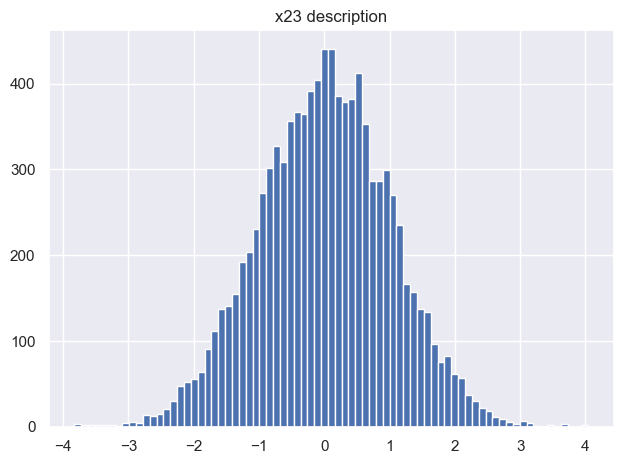

[-0.52756085 -1.18782713 -0.94252996 ...  0.16410474 -0.77561343
 -0.01253638]
count    9990.000000
mean        0.005865
std         0.998051
min        -3.535511
25%        -0.667380
50%         0.024934
75%         0.677624
max         4.021072
Name: x24, dtype: float64


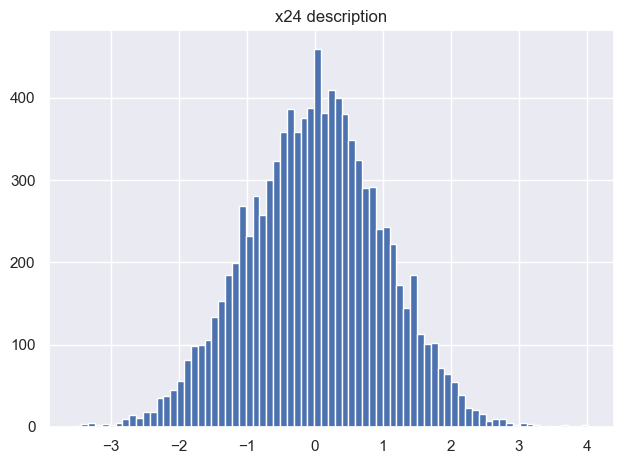

[-0.03824229 -0.925975   -0.97926384 ... -0.84582972 -1.96783186
 -0.0155292 ]
count    9986.000000
mean       -0.017696
std         1.009355
min        -3.636935
25%        -0.696725
50%        -0.011422
75%         0.671688
max         3.684245
Name: x25, dtype: float64


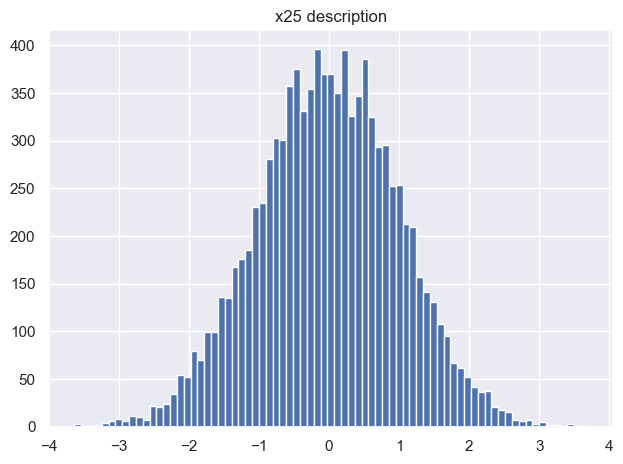

[-0.10295895  0.11176631 -0.39618797 ...  0.21194027 -0.24281927
 -0.41519552]
count    9988.000000
mean       -0.001471
std         1.001821
min        -4.001751
25%        -0.681478
50%         0.002140
75%         0.672399
max         3.648963
Name: x26, dtype: float64


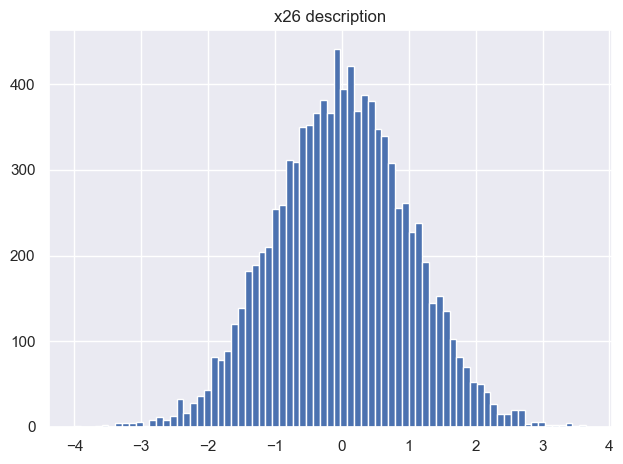

[-0.5472619   0.30514955 -0.92526237 ...  0.33367833 -0.05132269
  0.44740597]
count    9989.000000
mean       -0.000364
std         1.003845
min        -3.979287
25%        -0.678946
50%        -0.000204
75%         0.677066
max         4.203944
Name: x27, dtype: float64


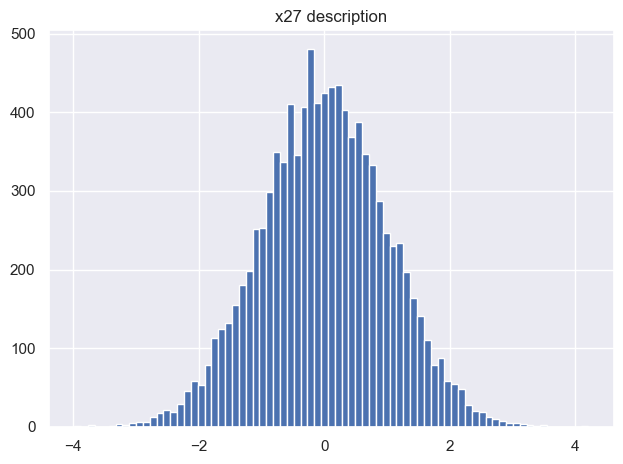

[-0.49062649 -0.23646807  1.07535853 ... -1.5039259   0.50860254
  0.32819996]
count    9987.000000
mean       -0.023590
std         1.001273
min        -3.685236
25%        -0.700753
50%        -0.017272
75%         0.659974
max         3.638723
Name: x28, dtype: float64


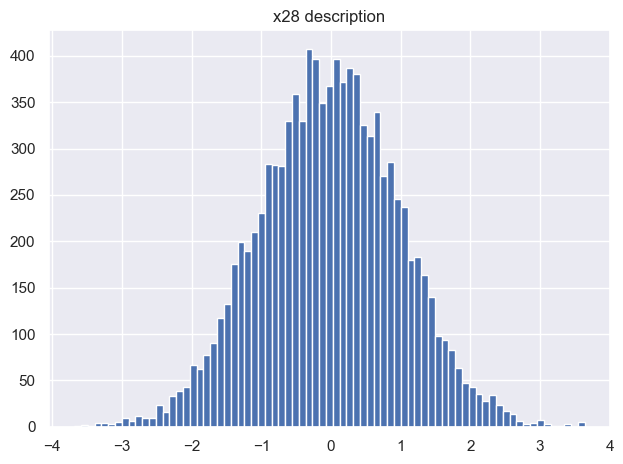

[-1.33305593  0.60279089  0.84265282 ... -1.2242187   0.40356443
 -0.37259784]
count    9996.000000
mean        0.099784
std         1.445985
min        -5.430942
25%        -0.880252
50%         0.004000
75%         0.784589
max         7.190733
Name: x29, dtype: float64


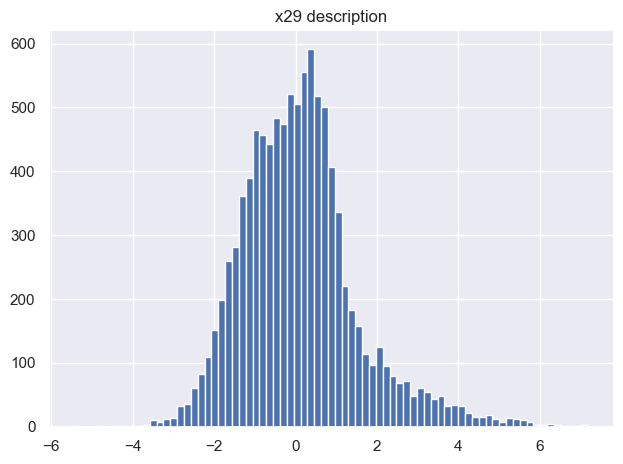

[ 0.01684875  0.25144098  0.49466306 ... -1.12833789 -0.61297109
  0.019681  ]
count    9991.000000
mean        0.005548
std         0.985745
min        -3.665171
25%        -0.666195
50%         0.002250
75%         0.663421
max         3.958804
Name: x30, dtype: float64


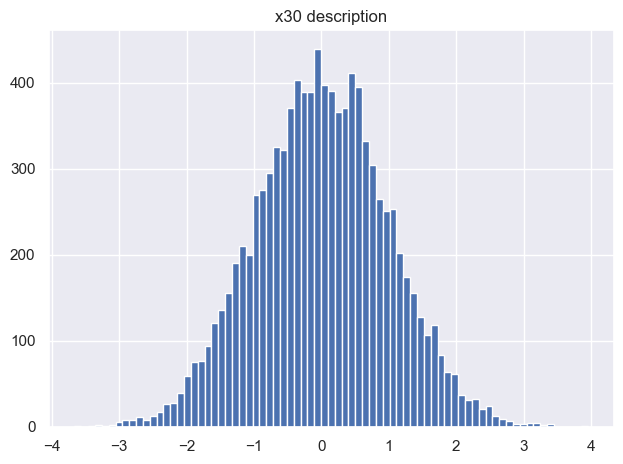

[-0.61164356  0.12671826  0.37282089 ...  0.36800164 -1.49121487
 -1.09878388]
count    9988.000000
mean       -0.004160
std         0.999237
min        -3.579802
25%        -0.656144
50%        -0.011517
75%         0.667586
max         3.855142
Name: x31, dtype: float64


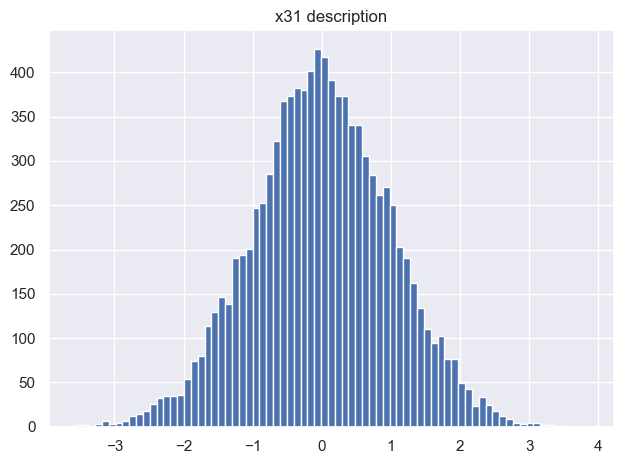

[ 1.80776498 -1.47861615  2.01970328 ...  0.23557295 -0.31981295
 -0.37818061]
count    9994.000000
mean       -0.007250
std         0.985222
min        -3.529604
25%        -0.676951
50%        -0.005109
75%         0.659724
max         3.345113
Name: x32, dtype: float64


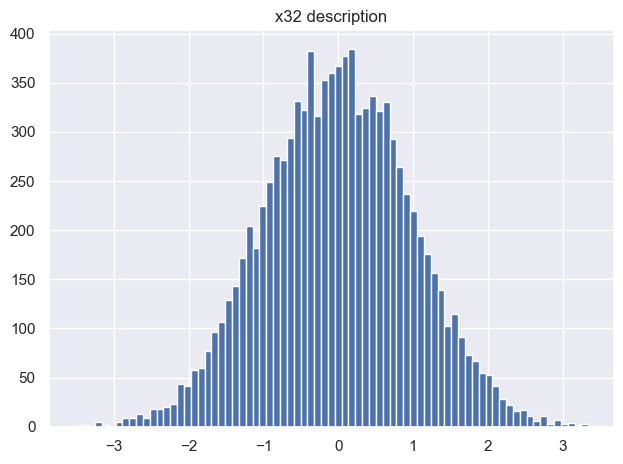

[ 0.08967707 -0.57393028  1.05918837 ...  0.99799872 -1.33918117
  1.92279085]
count    9992.000000
mean        0.497655
std         1.425038
min        -4.329571
25%        -0.614668
50%         0.494210
75%         1.493104
max         6.131138
Name: x33, dtype: float64


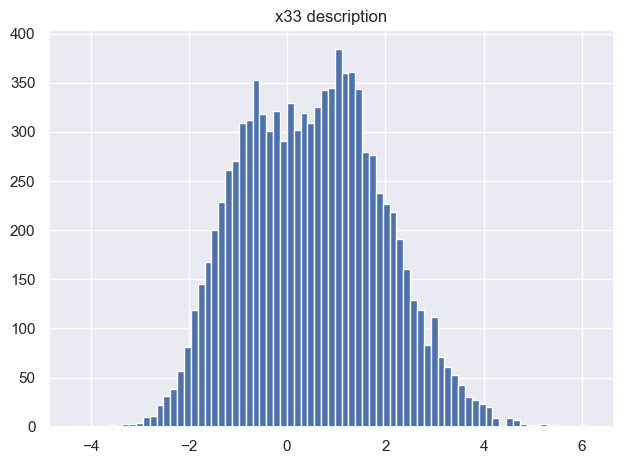

[-1.28977934 -0.30077678  1.71066713 ...  0.56266389  1.33221756
  1.03186638]
count    9993.000000
mean        0.004478
std         1.011723
min        -4.113791
25%        -0.677460
50%        -0.008408
75%         0.680082
max         4.712162
Name: x34, dtype: float64


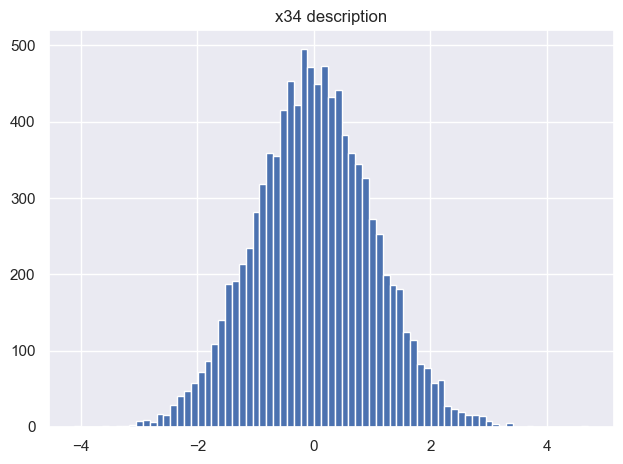

[ 0.30339247 -2.4895462  -0.39597094 ...  0.30995084  0.95340045
 -0.41812415]
count    9989.000000
mean        0.005869
std         0.998163
min        -3.733774
25%        -0.663888
50%         0.017655
75%         0.685904
max         3.550445
Name: x35, dtype: float64


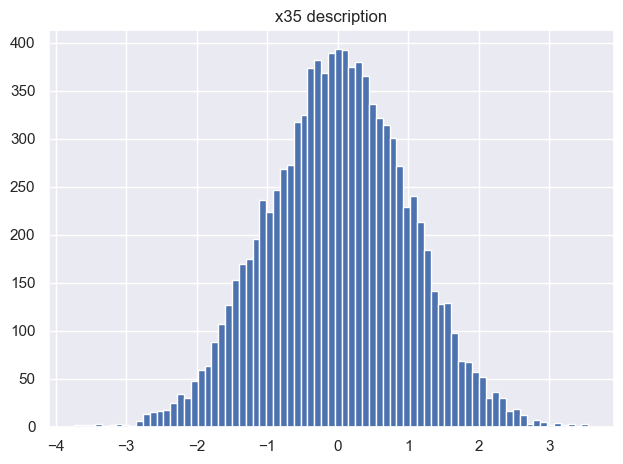

[ 0.79100121  1.10182586  0.5337675  ... -1.11110107 -0.69842284
 -0.30719678]
count    9990.000000
mean        0.001128
std         1.003915
min        -4.048466
25%        -0.668023
50%        -0.011583
75%         0.676087
max         3.670119
Name: x36, dtype: float64


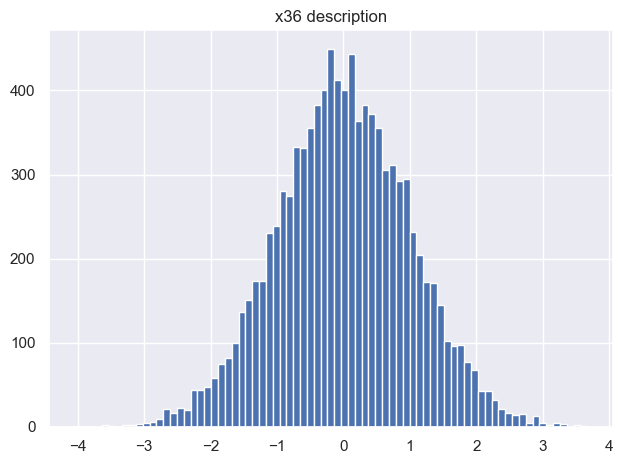

[-1.14766305 -0.73689738 -1.24500285 ...  0.67182385  1.22756144
  1.79527646]
count    9989.000000
mean        0.009065
std         1.002592
min        -4.259083
25%        -0.666668
50%         0.018341
75%         0.683876
max         4.111412
Name: x37, dtype: float64


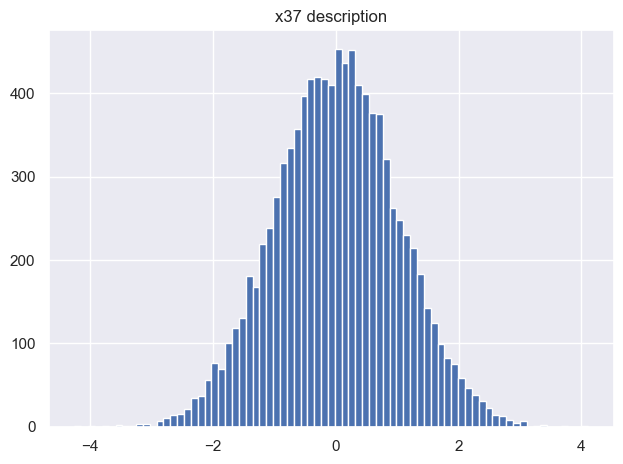

[ 0.31139514  1.109234    0.31581241 ...  0.36459031  0.48050426
 -0.06034039]
count    9987.000000
mean       -0.007062
std         1.008905
min        -4.944162
25%        -0.697490
50%        -0.005028
75%         0.679032
max         3.745125
Name: x38, dtype: float64


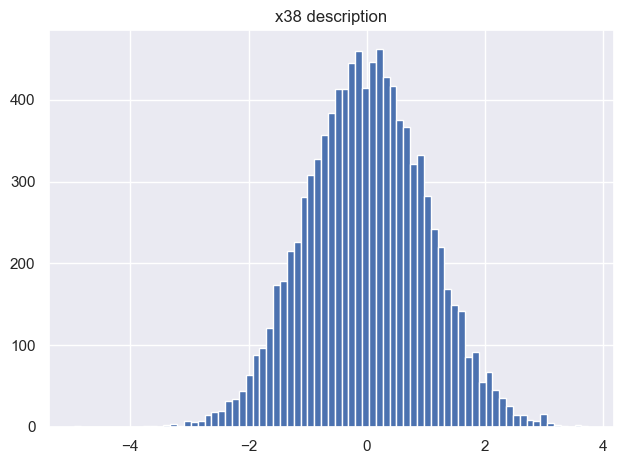

[-0.09747923  0.41148822 -0.69660702 ...  0.00508704 -0.02377067
 -0.24508251]
count    9992.000000
mean        0.015187
std         1.000228
min        -4.041515
25%        -0.653682
50%         0.012536
75%         0.685529
max         4.917545
Name: x39, dtype: float64


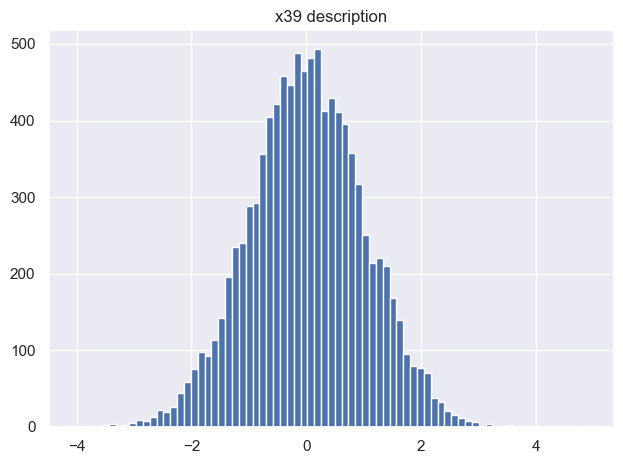

In [15]:
for var in float_vars:
    summarystats(data=df, var=var, titleplot=f'{var} description', n_bins=75)

#### Run summary statistics on each variable when y=1

[ 1.56331156  1.19439484 -0.92535571 ...  1.77078851  0.29324059
  1.91605876]
count    4995.000000
mean       -0.013636
std         0.982835
min        -3.607155
25%        -0.670334
50%        -0.007055
75%         0.641856
max         3.808301
Name: x0, dtype: float64


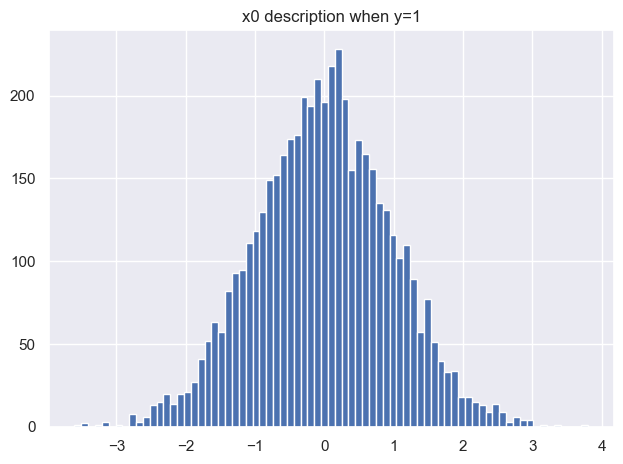

[-1.41745405 -1.54493237 -0.76583387 ...  0.93752126 -0.51010466
 -0.38422039]
count    4993.000000
mean       -0.007154
std         0.994612
min        -3.319745
25%        -0.663231
50%        -0.010247
75%         0.657170
max         3.653057
Name: x1, dtype: float64


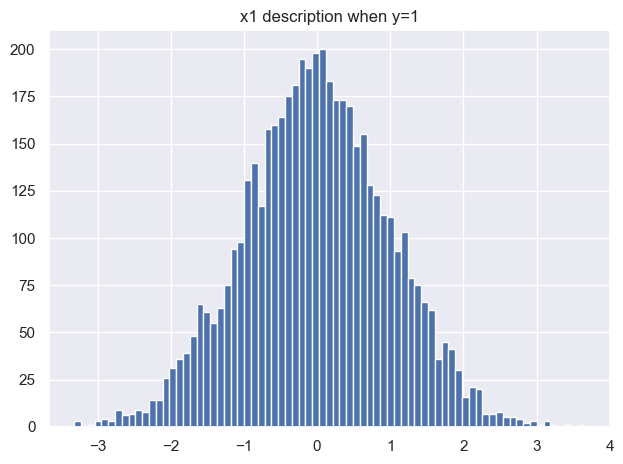

[-0.49021032  1.21945171  0.23256761 ... -1.52002389  0.83777624
 -2.04546235]
count    4996.000000
mean       -0.003240
std         0.995750
min        -3.712265
25%        -0.689356
50%        -0.008894
75%         0.681963
max         3.470688
Name: x2, dtype: float64


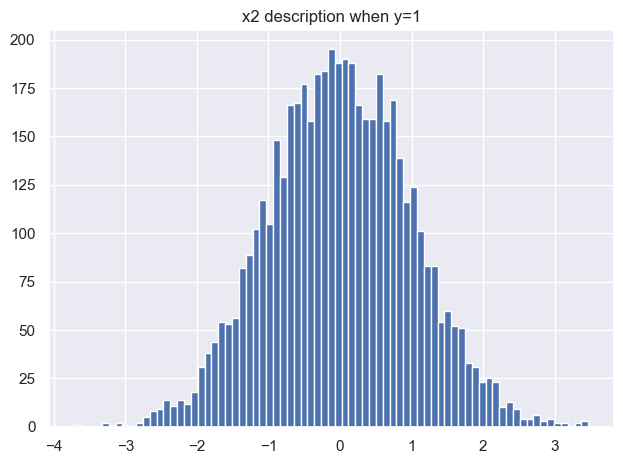

[-1.56868915  0.4456135   0.80117196 ... -0.53450102 -0.19274573
  0.23597387]
count    4997.000000
mean        0.003738
std         0.992534
min        -3.665978
25%        -0.670866
50%        -0.003068
75%         0.690189
max         3.593582
Name: x3, dtype: float64


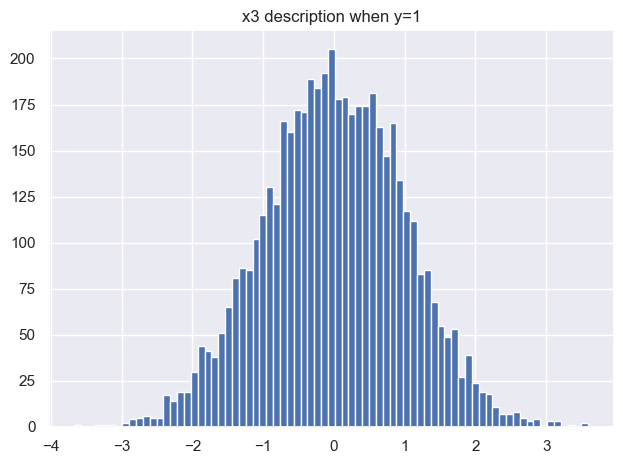

[ 0.36742095 -0.23690954 -0.2282325  ... -0.21609154 -0.17685229
  0.55447203]
count    4994.000000
mean       -0.000382
std         1.012104
min        -3.992339
25%        -0.668641
50%         0.010619
75%         0.660083
max         3.440192
Name: x4, dtype: float64


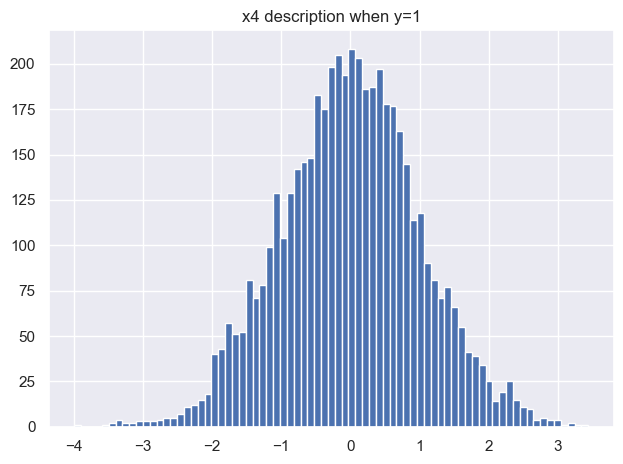

[ 0.07030344 -1.16949324  1.35459468 ... -1.14360272 -0.63888336
 -0.41678003]
count    4995.000000
mean        0.003778
std         0.999202
min        -3.374208
25%        -0.672007
50%         0.009041
75%         0.677588
max         3.614567
Name: x5, dtype: float64


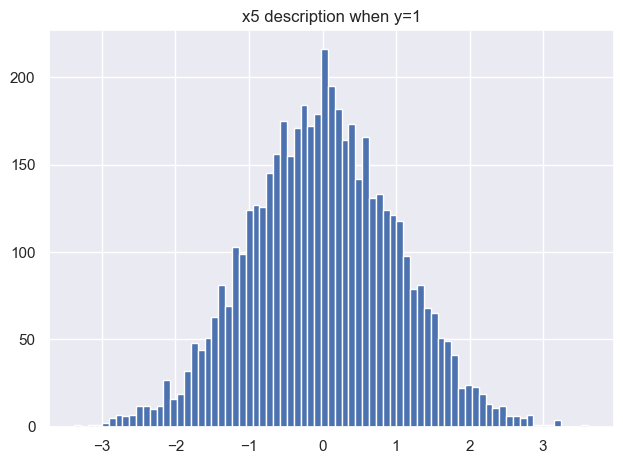

[-0.535064   -0.48469871 -0.95390932 ... -0.01202801 -0.71561908
  1.01927733]
count    4995.000000
mean       -0.002608
std         0.997801
min        -3.759752
25%        -0.684491
50%        -0.003856
75%         0.666704
max         3.251382
Name: x6, dtype: float64


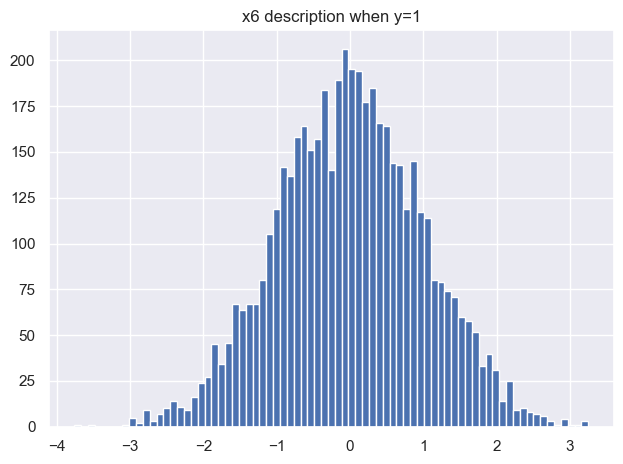

[ 0.16115388 -1.44713587 -1.47519601 ...  0.77477605 -0.97308676
  0.28058796]
count    4990.000000
mean       -0.007208
std         0.986994
min        -3.470438
25%        -0.666845
50%        -0.004468
75%         0.666575
max         3.613226
Name: x7, dtype: float64


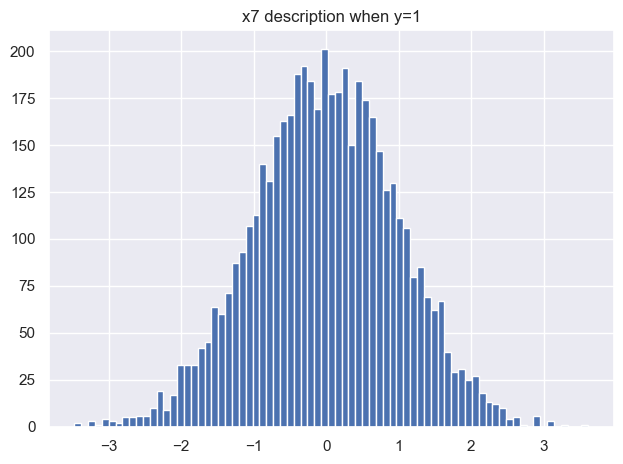

[ 0.13025494 -0.42251476  1.03901693 ...  1.20722895  0.68016548
 -1.0082216 ]
count    4997.000000
mean       -0.010549
std         0.984694
min        -3.419288
25%        -0.672964
50%        -0.003869
75%         0.657390
max         3.619799
Name: x8, dtype: float64


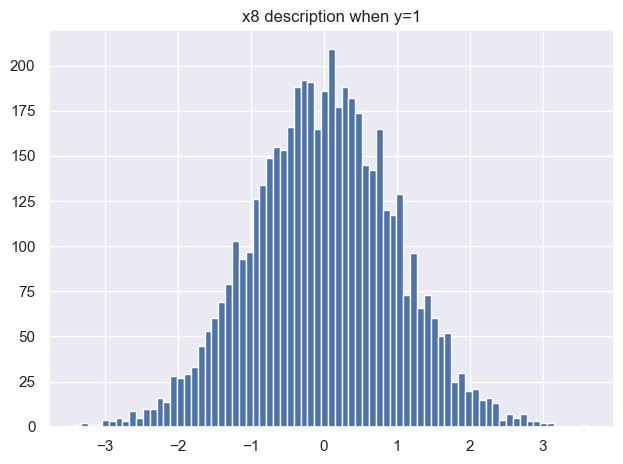

[ 0.75382275 -1.29761756  0.10952543 ... -1.2916609   2.1006561
 -0.85843339]
count    4994.000000
mean       -0.002883
std         1.002414
min        -3.674924
25%        -0.673887
50%        -0.009366
75%         0.668617
max         4.014372
Name: x9, dtype: float64


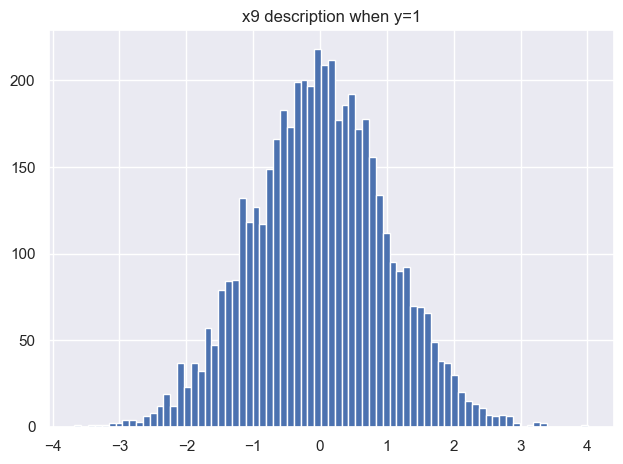

[ 1.53442659 -1.14366335 -0.96551586 ...  0.74921355 -0.97488994
 -1.56732691]
count    4995.000000
mean       -0.001741
std         1.004377
min        -4.580175
25%        -0.672350
50%        -0.008682
75%         0.672852
max         4.268941
Name: x10, dtype: float64


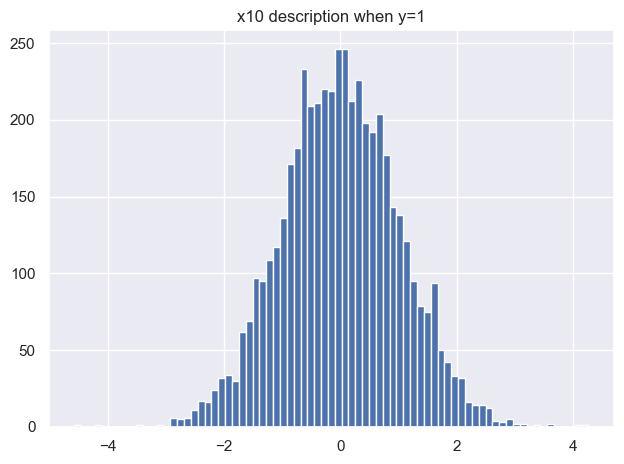

[ 0.40964743 -1.34168987 -0.47568203 ...  0.31791611  2.27005968
 -1.0500852 ]
count    4991.000000
mean        0.044145
std         0.980988
min        -3.355900
25%        -0.629563
50%         0.030822
75%         0.722864
max         3.672656
Name: x11, dtype: float64


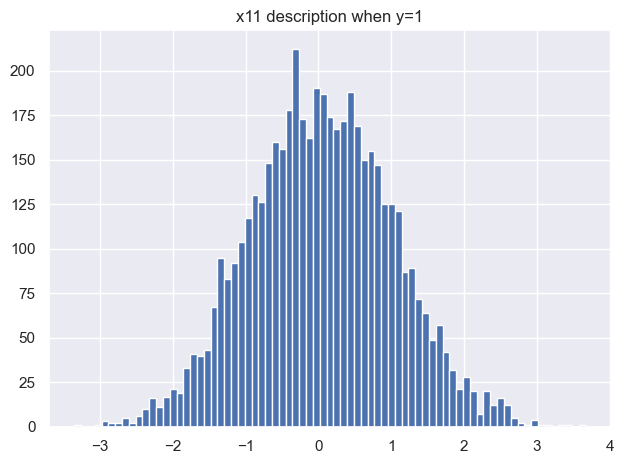

[ 0.83491938 -3.11149291 -2.51590404 ... -1.31087992 -0.23916023
  0.65594171]
count    4992.000000
mean        0.018057
std         0.988346
min        -4.058818
25%        -0.651943
50%         0.031076
75%         0.685749
max         3.462487
Name: x12, dtype: float64


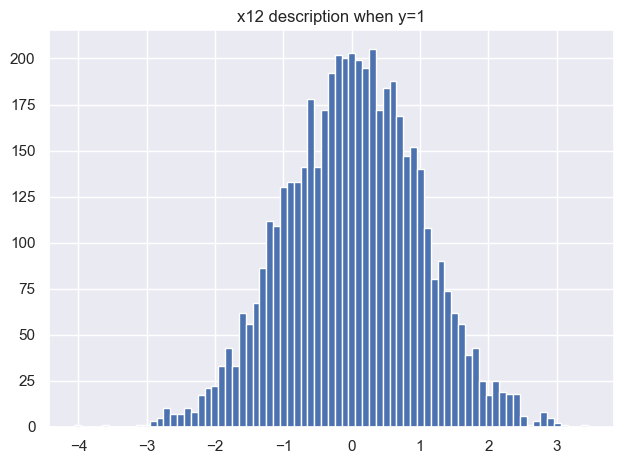

[1.29870877 1.67997142 0.31213115 ... 0.34405949 0.92994117 0.65104113]
count    4992.000000
mean        1.005884
std         0.691365
min        -1.177047
25%         0.527651
50%         1.006683
75%         1.469068
max         3.594899
Name: x13, dtype: float64


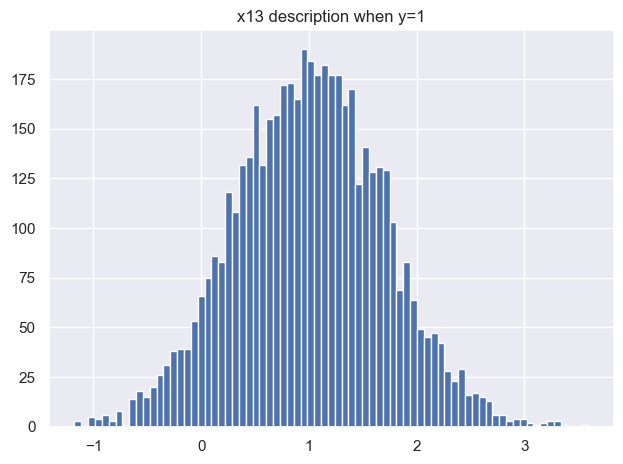

[ 0.05800927  0.09562249 -1.56411241 ...  0.00582313  0.5742933
  1.05116339]
count    4994.000000
mean        0.000564
std         1.012996
min        -3.699685
25%        -0.678841
50%        -0.001831
75%         0.666151
max         3.990200
Name: x14, dtype: float64


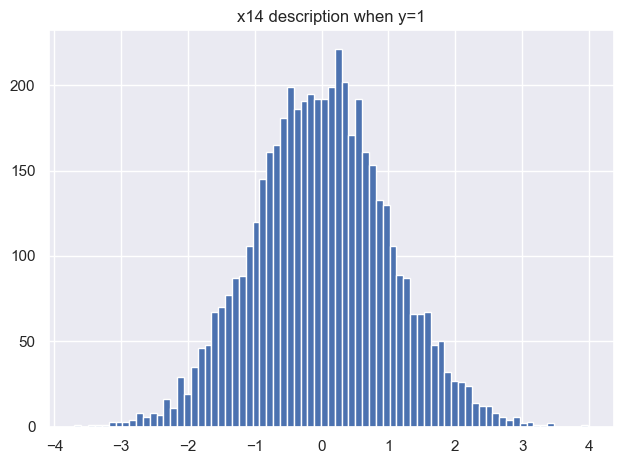

[ 0.54542221  0.79077978 -1.96155684 ...  0.28789909  0.85075083
 -0.48828966]
count    4997.000000
mean       -0.328339
std         1.099626
min        -4.225551
25%        -1.064181
50%        -0.328530
75%         0.425489
max         3.398397
Name: x15, dtype: float64


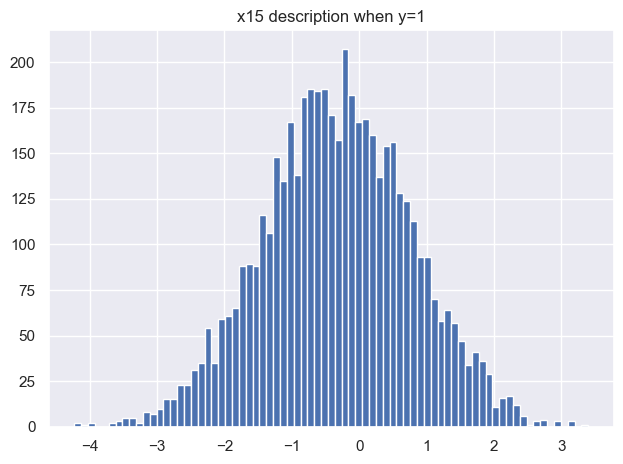

[ 0.478652           nan -0.40362776 ...  0.94354966  0.81166862
  0.42315783]
count    4995.000000
mean       -0.010678
std         0.993728
min        -3.281509
25%        -0.670454
50%        -0.023708
75%         0.667392
max         3.438530
Name: x16, dtype: float64


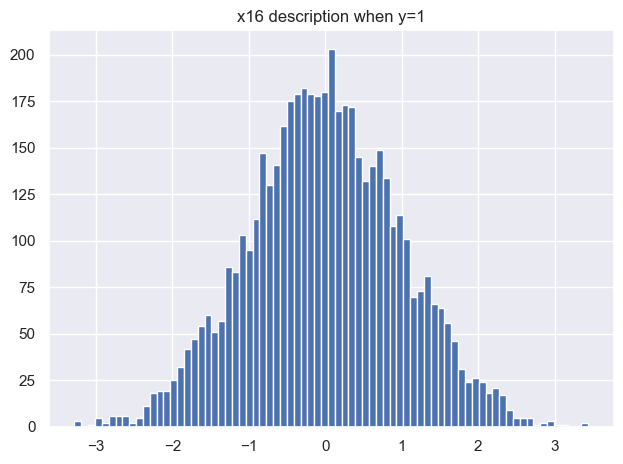

[-0.13564114  0.81509191 -0.87145377 ... -0.32907766 -1.7632811
 -0.71217301]
count    4994.000000
mean       -0.017304
std         1.008902
min        -3.830807
25%        -0.695735
50%        -0.040940
75%         0.665491
max         4.293922
Name: x17, dtype: float64


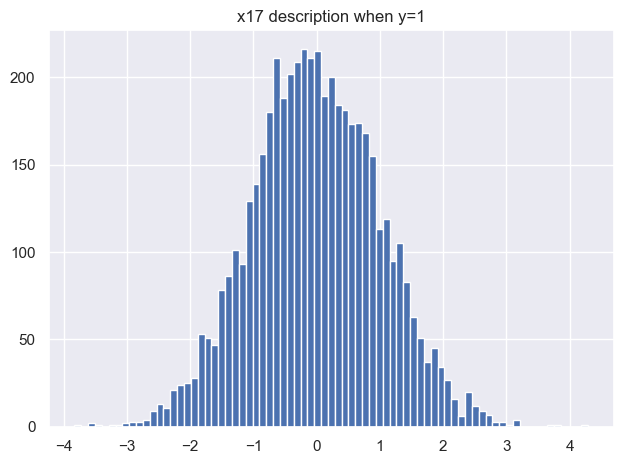

[-0.72882459 -1.15904406  0.18265275 ... -0.94683971 -0.34987095
 -1.47455637]
count    4993.000000
mean       -0.006113
std         1.010808
min        -4.458664
25%        -0.683532
50%        -0.016966
75%         0.662317
max         3.433304
Name: x18, dtype: float64


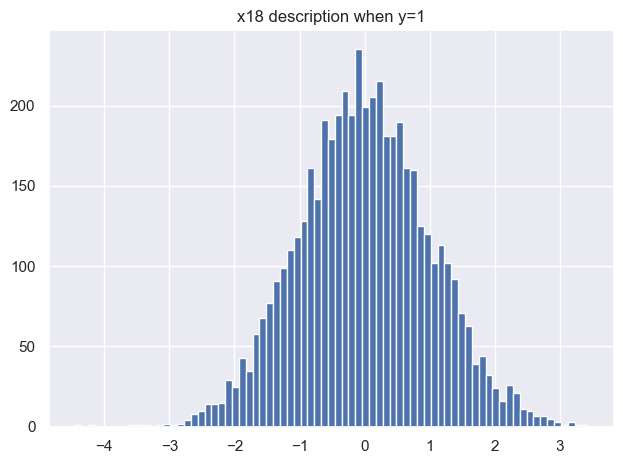

[-0.80149564 -0.30848713  0.52036928 ... -0.62832881  0.78637611
 -0.28794563]
count    4993.000000
mean       -0.006096
std         1.001877
min        -3.886170
25%        -0.692385
50%        -0.017821
75%         0.680676
max         3.921642
Name: x19, dtype: float64


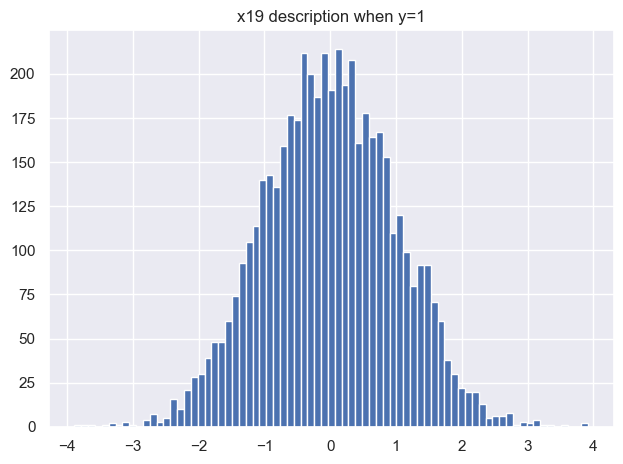

[-0.80521082 -0.26434993 -0.10939144 ... -0.7020052  -2.51027732
 -0.76841828]
count    4998.000000
mean       -0.019860
std         1.282276
min        -3.724026
25%        -1.030171
50%        -0.111112
75%         0.991237
max         3.766584
Name: x20, dtype: float64


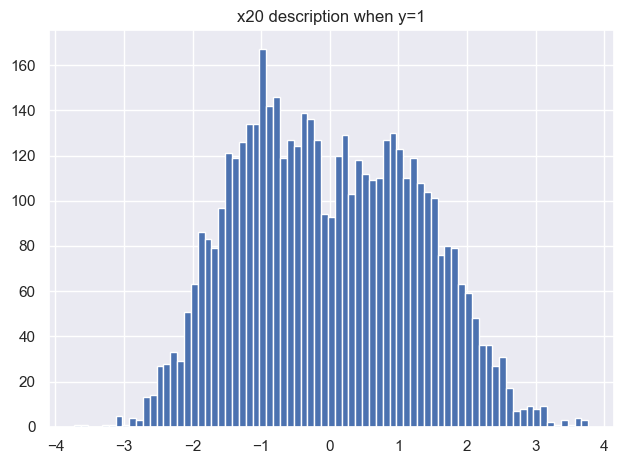

[ 0.09448542  0.93626445 -0.76621054 ...  0.00723518 -0.0834389
  0.26935203]
count    4998.000000
mean       -0.010458
std         1.002697
min        -3.861712
25%        -0.688089
50%        -0.007167
75%         0.657824
max         4.024593
Name: x21, dtype: float64


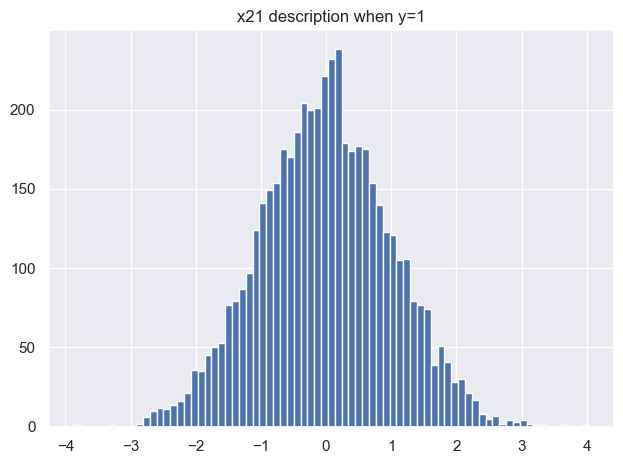

[ 0.46742139  2.20453437 -0.74694296 ... -0.35042969 -0.4474846
  0.46136641]
count    4997.000000
mean       -0.004802
std         1.000918
min        -4.066952
25%        -0.694887
50%        -0.000151
75%         0.693527
max         3.402088
Name: x22, dtype: float64


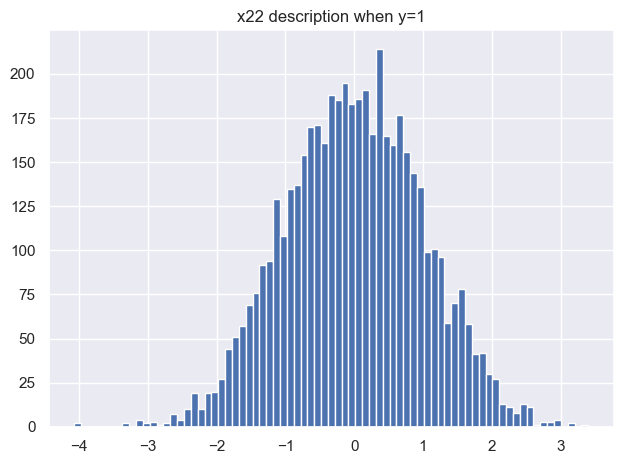

[ 0.18549756  1.0573995  -0.85834417 ... -1.38790851  0.90942874
 -1.0586624 ]
count    4996.000000
mean        0.014470
std         1.016096
min        -3.795134
25%        -0.662899
50%         0.026148
75%         0.693043
max         4.043102
Name: x23, dtype: float64


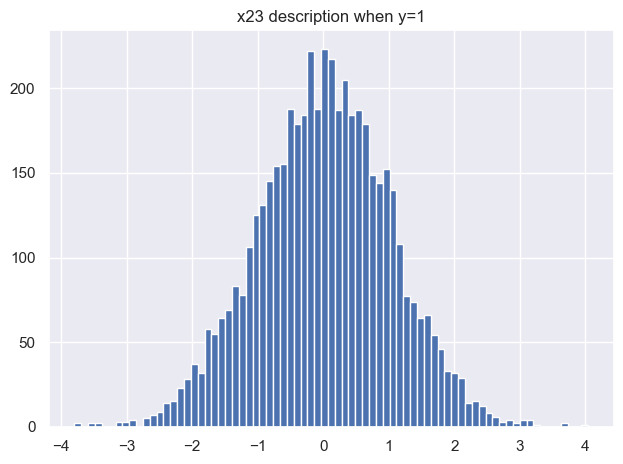

[-0.52756085 -0.16292532  0.94397193 ... -0.00756421  0.16410474
 -0.01253638]
count    4994.000000
mean        0.006266
std         0.985407
min        -3.363073
25%        -0.660950
50%         0.023428
75%         0.683332
max         3.977963
Name: x24, dtype: float64


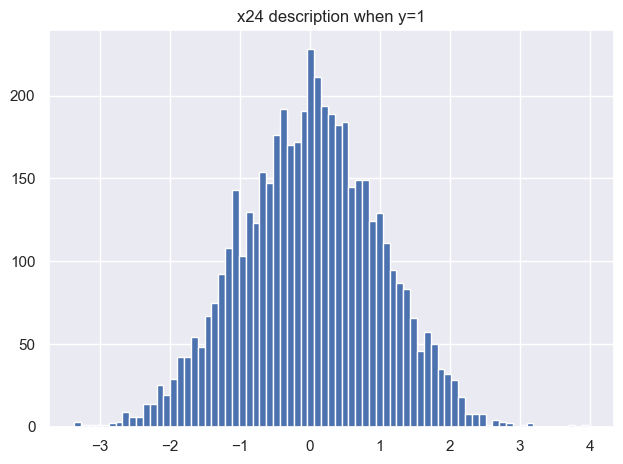

[-0.03824229 -0.16331583  0.68724411 ... -0.53389577 -0.84582972
 -0.0155292 ]
count    4993.000000
mean       -0.027280
std         1.001057
min        -3.603713
25%        -0.702195
50%        -0.018499
75%         0.639605
max         3.684245
Name: x25, dtype: float64


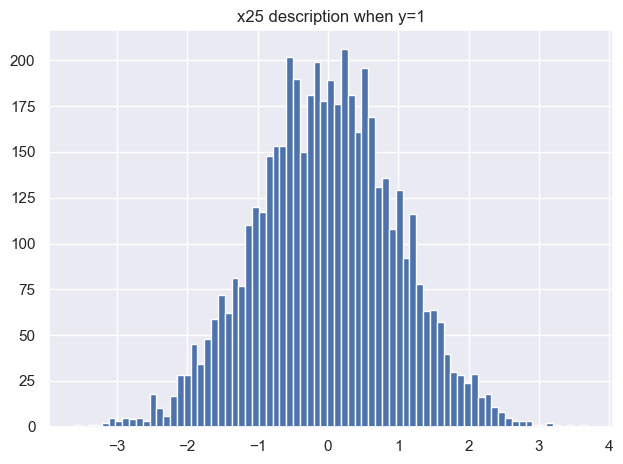

[-0.10295895 -0.7951204  -0.43301672 ...  1.06013667  0.21194027
 -0.41519552]
count    4994.000000
mean       -0.003572
std         0.989278
min        -3.510557
25%        -0.683542
50%         0.006675
75%         0.653443
max         3.648963
Name: x26, dtype: float64


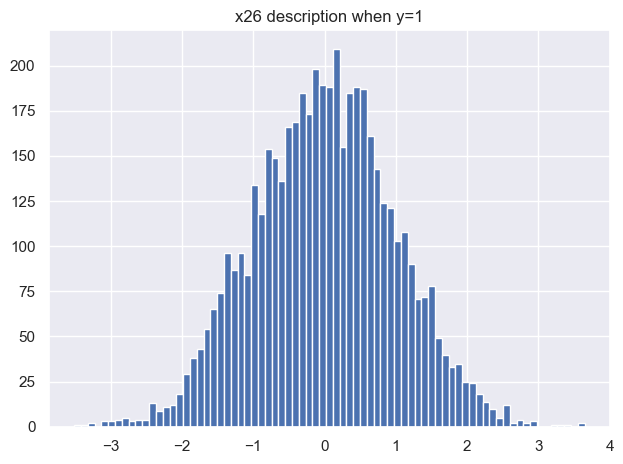

[-0.5472619   0.04983926  1.69413555 ... -1.71271747  0.33367833
  0.44740597]
count    4995.000000
mean       -0.006329
std         1.003483
min        -3.979287
25%        -0.689591
50%         0.004475
75%         0.667840
max         3.474030
Name: x27, dtype: float64


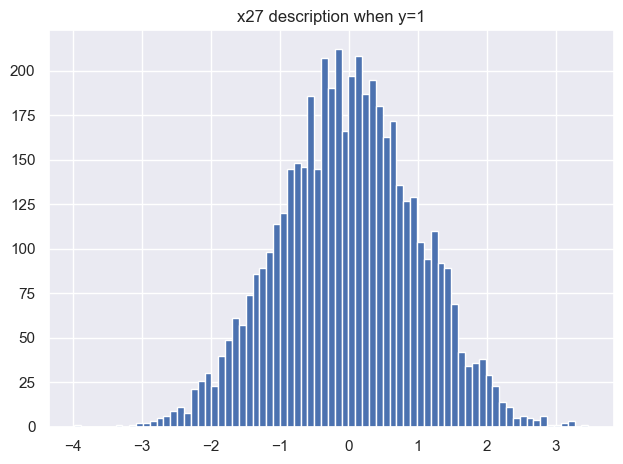

[-0.49062649  0.56300763 -2.04539217 ...  0.70064496 -1.5039259
  0.32819996]
count    4994.000000
mean       -0.020711
std         1.008618
min        -3.580103
25%        -0.699064
50%        -0.029303
75%         0.665093
max         3.638723
Name: x28, dtype: float64


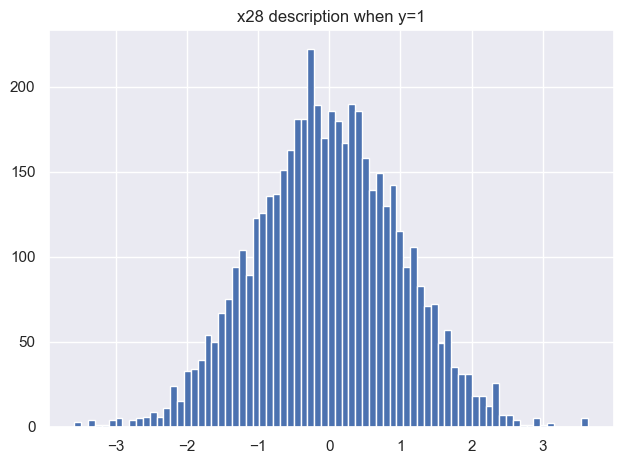

[-1.33305593 -1.72635833  0.53780092 ... -0.4323814  -1.2242187
 -0.37259784]
count    4997.000000
mean       -0.700540
std         0.910159
min        -3.670093
25%        -1.304206
50%        -0.746190
75%        -0.119637
max         2.718666
Name: x29, dtype: float64


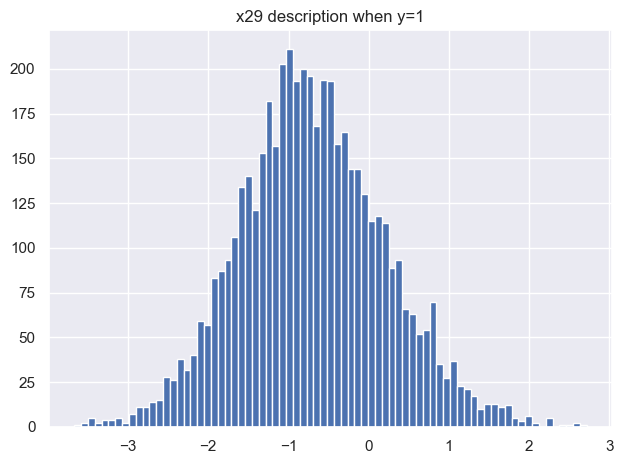

[ 0.01684875  0.59538346 -0.71095165 ... -0.38473873 -1.12833789
  0.019681  ]
count    4995.000000
mean       -0.000579
std         0.983467
min        -3.665171
25%        -0.670770
50%        -0.005169
75%         0.642144
max         3.415738
Name: x30, dtype: float64


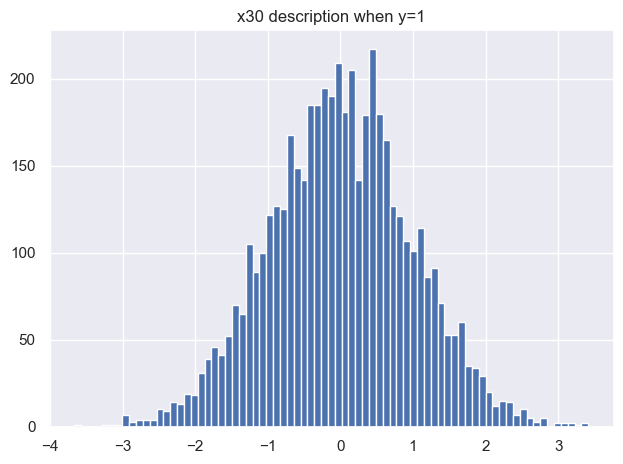

[-0.61164356 -0.63487631 -0.88839283 ... -1.24486898  0.36800164
 -1.09878388]
count    4994.000000
mean       -0.011697
std         0.996288
min        -3.579802
25%        -0.655306
50%        -0.017973
75%         0.644489
max         3.319794
Name: x31, dtype: float64


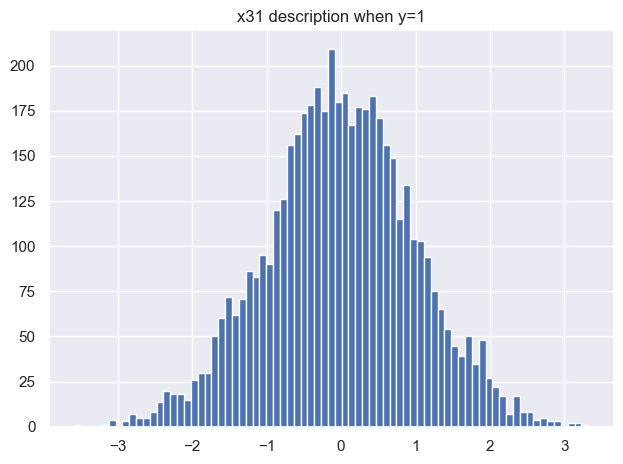

[ 1.80776498 -1.01664065  0.33011598 ...  0.38681376  0.23557295
 -0.37818061]
count    4997.000000
mean       -0.023478
std         0.990862
min        -3.414327
25%        -0.709719
50%        -0.018881
75%         0.663225
max         3.345113
Name: x32, dtype: float64


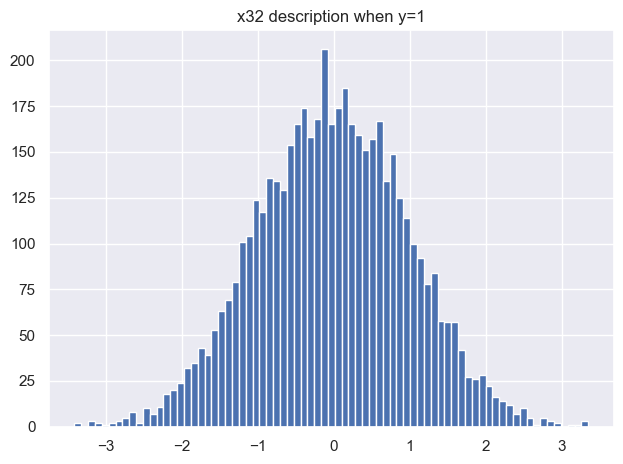

[ 0.08967707 -0.80123759  4.13752634 ...  0.20539155  0.99799872
  1.92279085]
count    4996.000000
mean        0.995353
std         1.367886
min        -4.329571
25%         0.091557
50%         1.010700
75%         1.914155
max         6.131138
Name: x33, dtype: float64


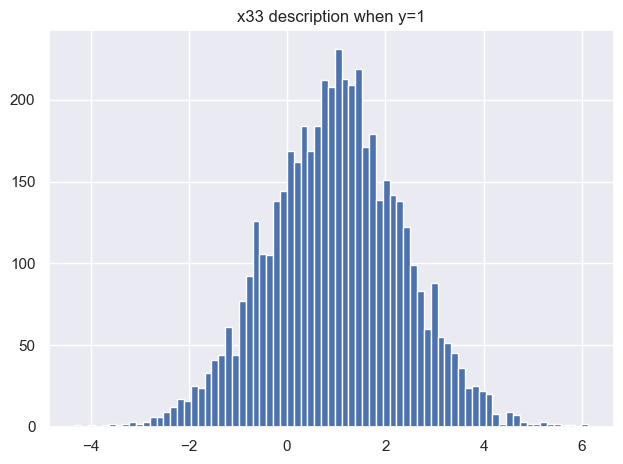

[-1.28977934 -0.86894501  0.8283305  ... -0.62087363  0.56266389
  1.03186638]
count    4994.000000
mean        0.003606
std         1.020764
min        -3.540878
25%        -0.685301
50%        -0.012600
75%         0.679659
max         3.733252
Name: x34, dtype: float64


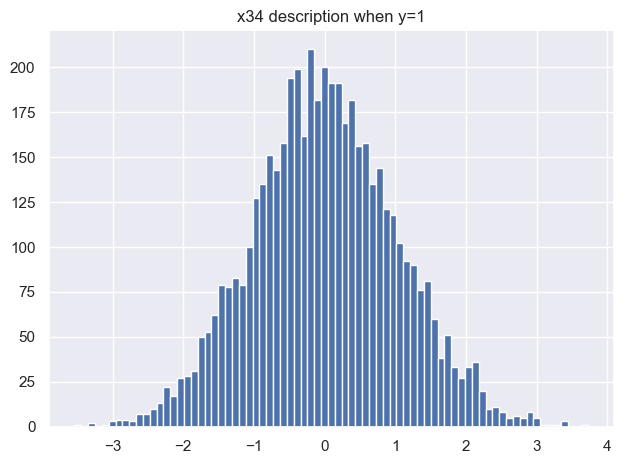

[ 0.30339247 -1.47087141  0.68157099 ...  0.51556252  0.30995084
 -0.41812415]
count    4994.000000
mean       -0.006838
std         1.005699
min        -3.733774
25%        -0.680645
50%         0.004746
75%         0.683865
max         3.490080
Name: x35, dtype: float64


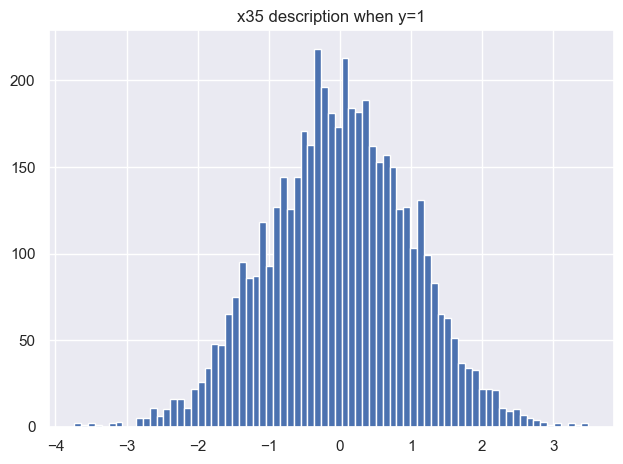

[ 0.79100121  0.4487379  -0.56252558 ... -0.54009834 -1.11110107
 -0.30719678]
count    4996.000000
mean        0.002677
std         1.009270
min        -4.048466
25%        -0.667074
50%        -0.019131
75%         0.684563
max         3.305826
Name: x36, dtype: float64


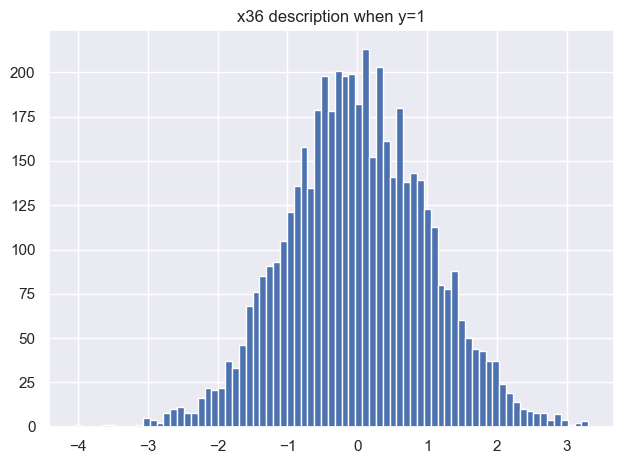

[-1.14766305  1.09864451 -0.71030705 ...  1.14849293  0.67182385
  1.79527646]
count    4995.000000
mean        0.008041
std         1.003762
min        -3.935286
25%        -0.667085
50%         0.014394
75%         0.687980
max         4.111412
Name: x37, dtype: float64


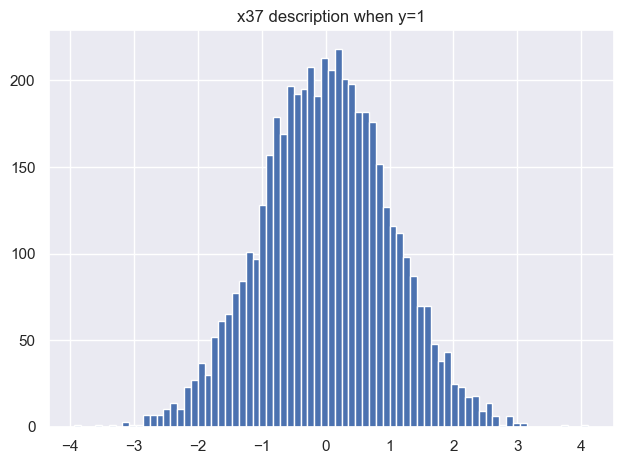

[ 0.31139514 -0.71732858 -0.93337817 ...  0.51172704  0.36459031
 -0.06034039]
count    4996.000000
mean       -0.008834
std         1.006656
min        -3.726854
25%        -0.684203
50%        -0.005230
75%         0.669080
max         3.609406
Name: x38, dtype: float64


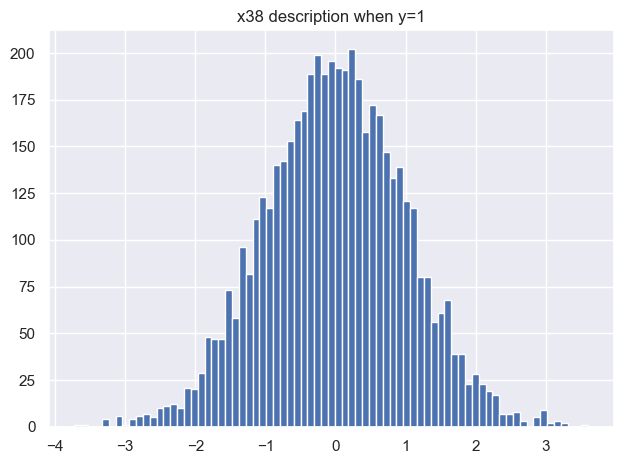

[-0.09747923 -1.00681024  0.02111312 ...  1.04176647  0.00508704
 -0.24508251]
count    4996.000000
mean        0.032612
std         0.997431
min        -4.041515
25%        -0.639912
50%         0.041839
75%         0.713749
max         4.917545
Name: x39, dtype: float64


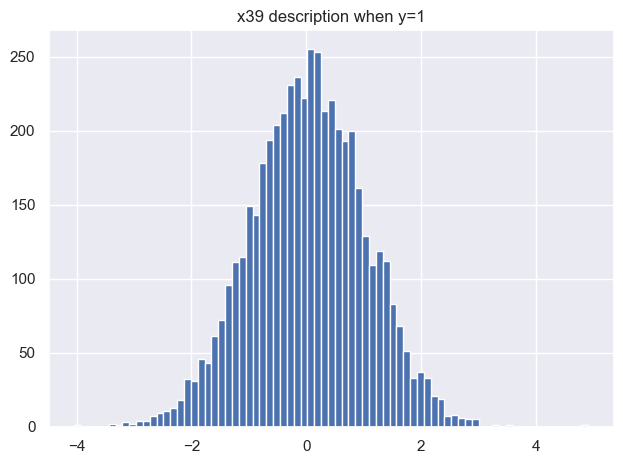

In [16]:
for var in float_vars:
    summarystats(data=df[df['y']==1], var=var, titleplot=f'{var} description when y=1', n_bins=75)

#### Run summary statistics on each variable when y=0

[-1.95217853  0.966699    0.2457896  ... -0.942567   -0.85301672
  0.5822515 ]
count    4994.000000
mean        0.003261
std         0.990161
min        -3.349235
25%        -0.675915
50%        -0.006583
75%         0.660628
max         3.425848
Name: x0, dtype: float64


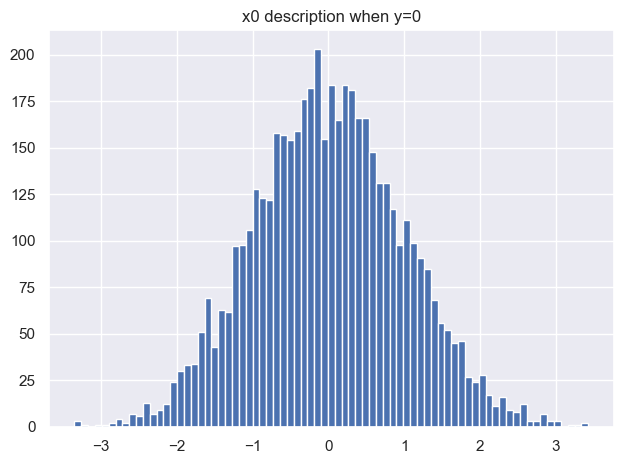

[ 0.12701261 -0.47627632  0.21722569 ...  0.56520564 -1.38154552
 -0.00471088]
count    4993.000000
mean       -0.003735
std         0.989318
min        -3.443086
25%        -0.671554
50%        -0.015528
75%         0.648680
max         3.686834
Name: x1, dtype: float64


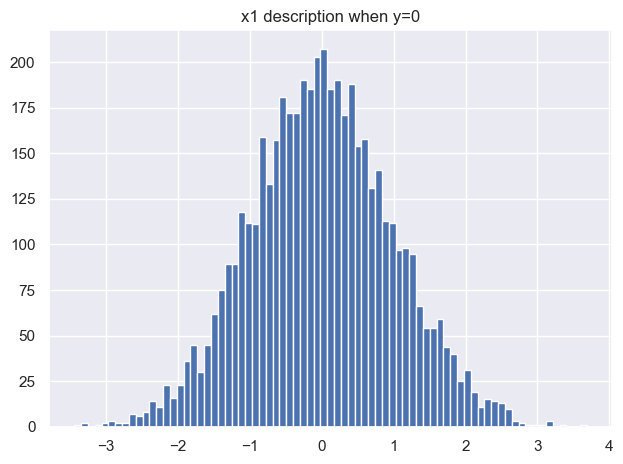

[ 1.53829849  0.49171341  0.04432087 ...  0.36256843 -0.21883751
 -1.84531471]
count    4994.000000
mean       -0.026122
std         0.996550
min        -3.463411
25%        -0.706949
50%        -0.036400
75%         0.650869
max         3.221692
Name: x2, dtype: float64


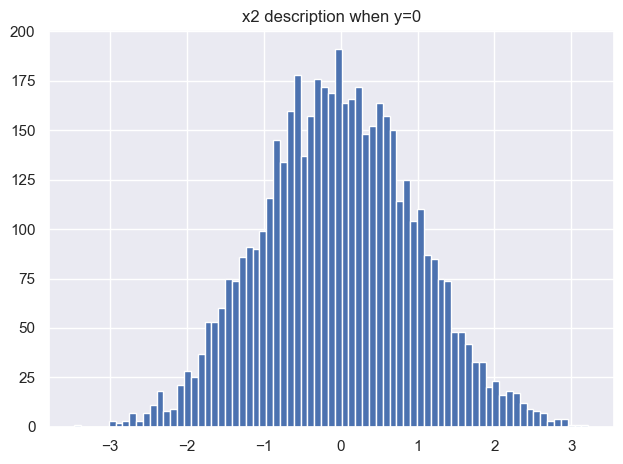

[ 0.34690556  1.77852068  0.74113214 ...  0.49580678 -1.30527685
  0.59574029]
count    4991.000000
mean       -0.012990
std         0.997309
min        -3.418404
25%        -0.666605
50%        -0.026537
75%         0.661054
max         3.670963
Name: x3, dtype: float64


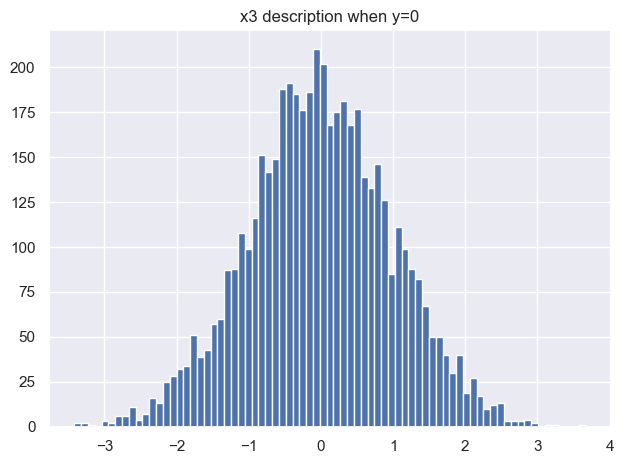

[ 1.18842391 -0.97724283  2.28713892 ...  0.72002333  2.04542925
  0.55261497]
count    4997.000000
mean        0.037495
std         0.999198
min        -3.527703
25%        -0.635362
50%         0.015158
75%         0.708630
max         3.491511
Name: x4, dtype: float64


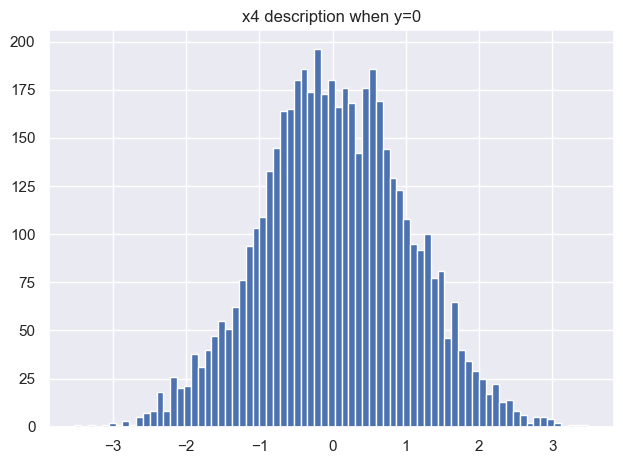

[ 0.81258326 -0.46530664 -0.01371481 ...  0.6931625   1.25741055
  0.72776655]
count    4997.000000
mean       -0.003165
std         1.006415
min        -3.219591
25%        -0.723430
50%         0.008909
75%         0.667866
max         4.496129
Name: x5, dtype: float64


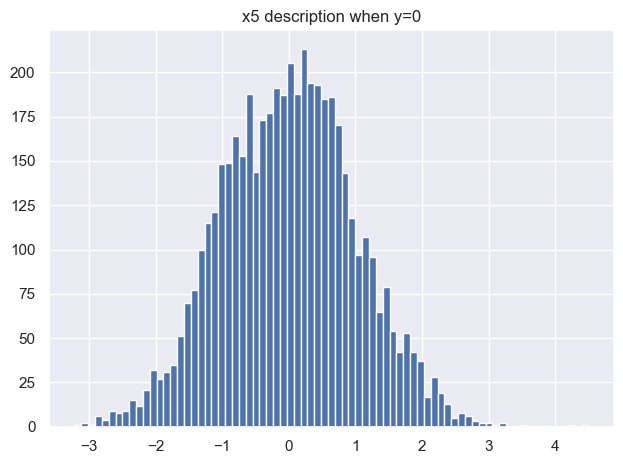

[-0.93155927 -1.0262942  -0.35932675 ...  0.89994625 -1.83645267
  0.12115315]
count    4996.000000
mean        0.003385
std         1.020813
min        -4.472915
25%        -0.687106
50%         0.021315
75%         0.678993
max         3.753948
Name: x6, dtype: float64


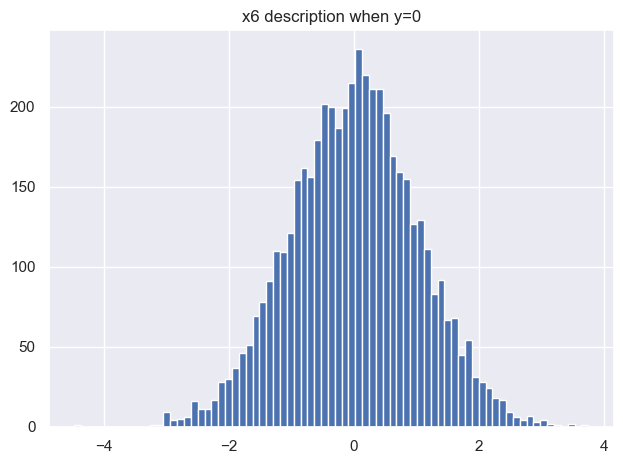

[ 0.81511449  0.52678694  0.51077721 ...  1.09605875  0.44226202
 -1.21256305]
count    4995.000000
mean       -0.002237
std         1.008205
min        -3.955288
25%        -0.701062
50%         0.021345
75%         0.689600
max         3.141192
Name: x7, dtype: float64


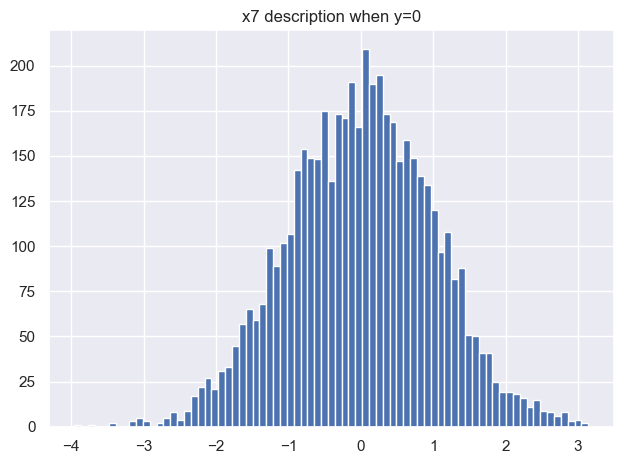

[-0.33113506 -0.42304758  0.76533419 ... -0.97498799  0.03848699
  1.30993674]
count    4994.000000
mean        0.019924
std         1.008999
min        -3.193413
25%        -0.646524
50%         0.030847
75%         0.695734
max         3.502460
Name: x8, dtype: float64


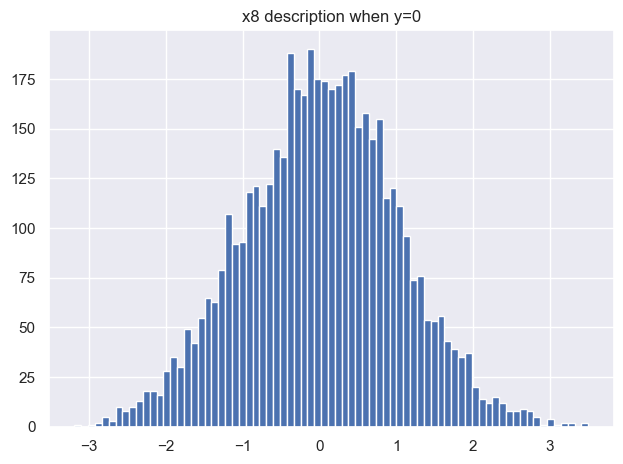

[-1.20211019  1.58442099  0.65509583 ...  0.15635003  0.78128888
  0.89112865]
count    4995.000000
mean       -0.005721
std         1.011634
min        -4.007732
25%        -0.686439
50%        -0.012561
75%         0.685789
max         3.617470
Name: x9, dtype: float64


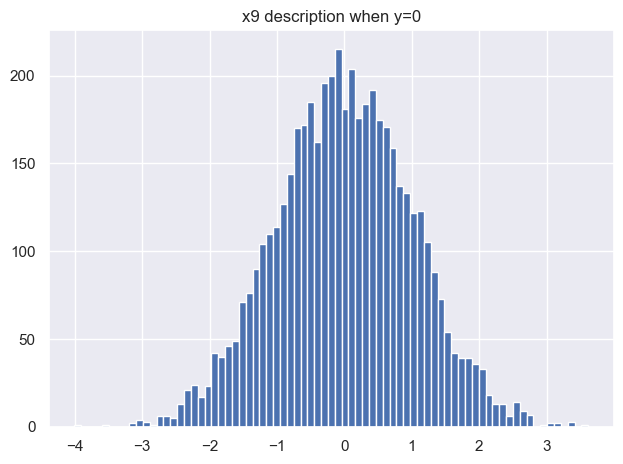

[ 0.61308431  1.57311709  1.04121451 ... -0.69504505 -0.11405649
 -1.59888419]
count    4998.000000
mean       -0.019582
std         0.993031
min        -3.798902
25%        -0.704315
50%        -0.007494
75%         0.650740
max         3.821319
Name: x10, dtype: float64


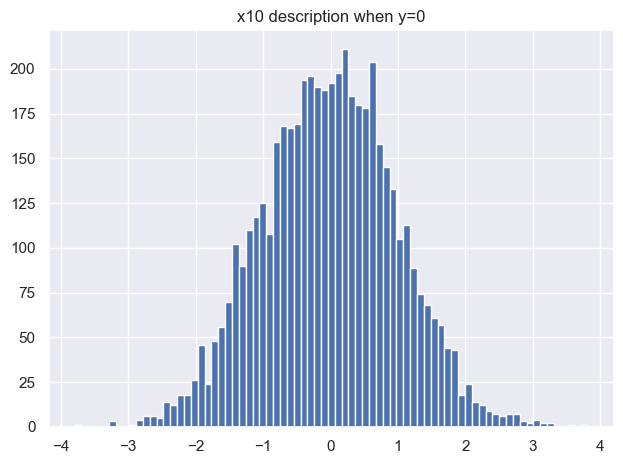

[ 0.96051881 -1.44757306 -0.75979466 ...  1.15840707 -0.06492712
  0.05063622]
count    4991.000000
mean       -0.004114
std         0.988523
min        -3.797071
25%        -0.666280
50%        -0.007994
75%         0.646369
max         3.496279
Name: x11, dtype: float64


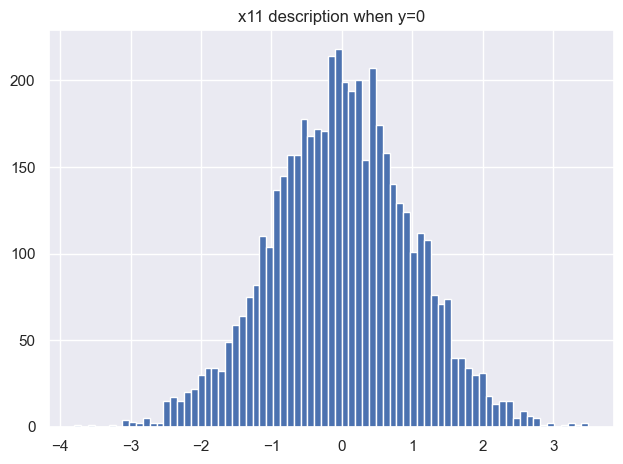

[-0.23674973  0.07713486  0.94519795 ... -0.91874325 -0.58266409
 -0.69539544]
count    4995.000000
mean       -0.007241
std         1.010999
min        -3.788957
25%        -0.692365
50%        -0.014533
75%         0.674364
max         3.393908
Name: x12, dtype: float64


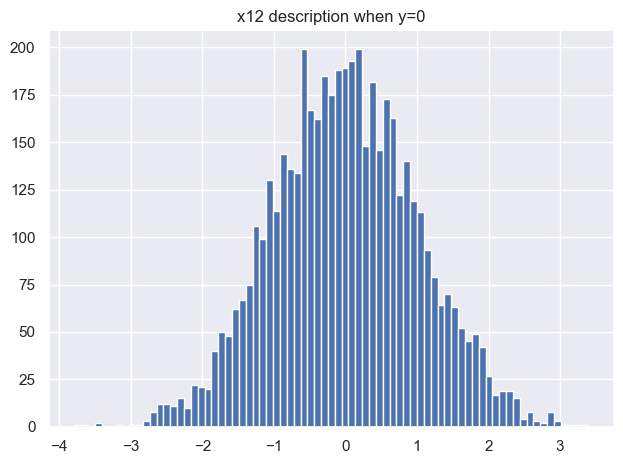

[-0.93676283 -0.41575323 -1.01363164 ... -0.09671615  2.16579106
 -1.10652315]
count    4995.000000
mean       -1.006459
std         1.198201
min        -6.140022
25%        -1.511401
50%        -1.010535
75%        -0.523259
max         4.943139
Name: x13, dtype: float64


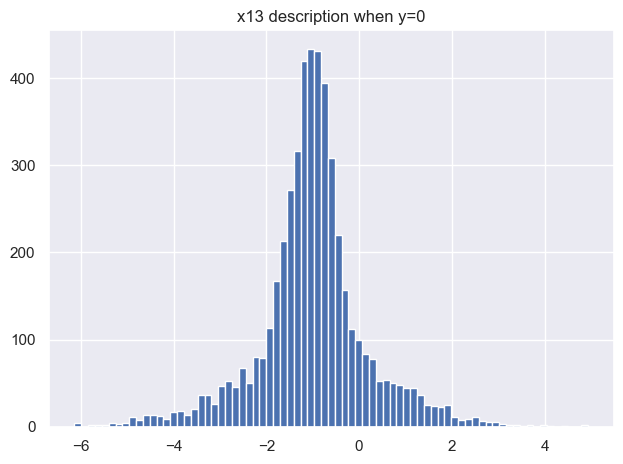

[ 0.21354268 -0.08672329 -0.67162561 ... -0.20362789 -1.85045887
  0.54160233]
count    4998.000000
mean        0.024697
std         1.000974
min        -3.782551
25%        -0.667193
50%         0.006598
75%         0.717085
max         3.584352
Name: x14, dtype: float64


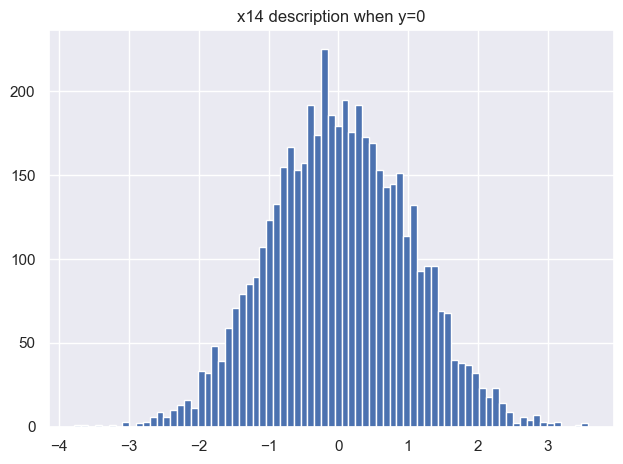

[ 0.37400327 -1.1083889  -1.40650953 ... -0.56120378  1.21316886
  1.12143456]
count    4997.000000
mean       -0.161445
std         1.376281
min        -4.848131
25%        -1.136636
50%         0.070715
75%         0.866764
max         3.520093
Name: x15, dtype: float64


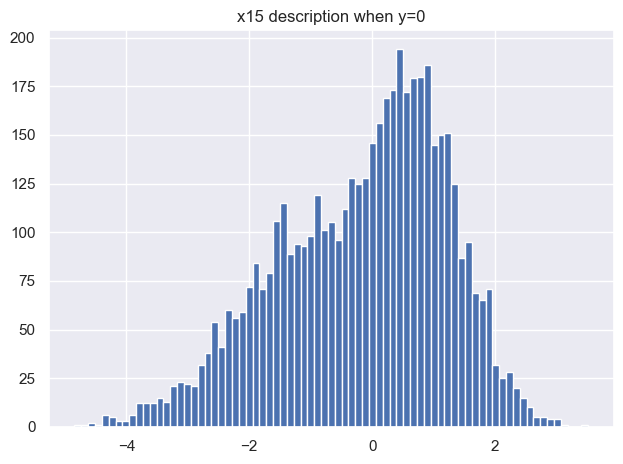

[ 2.84390162 -0.33214393 -1.87044238 ...  0.06297618  0.29393214
 -1.97806824]
count    4997.000000
mean        0.002502
std         1.001276
min        -4.024865
25%        -0.682264
50%        -0.000397
75%         0.665319
max         3.501516
Name: x16, dtype: float64


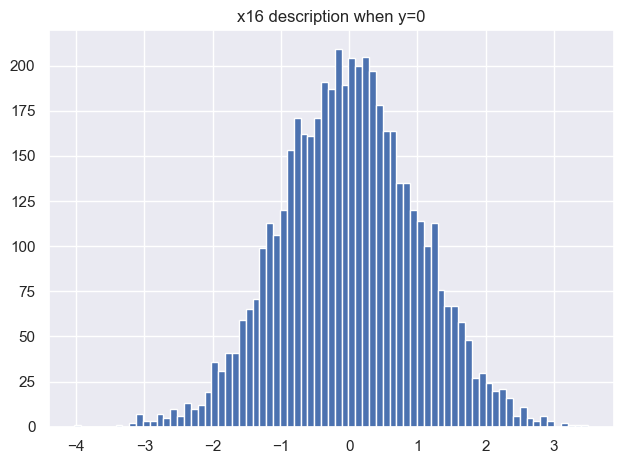

[-0.50729077 -0.17393181 -0.13979676 ... -0.35982605  0.51047542
  0.75102083]
count    4994.000000
mean        0.030278
std         1.001225
min        -3.977414
25%        -0.640336
50%         0.043093
75%         0.688823
max         3.947486
Name: x17, dtype: float64


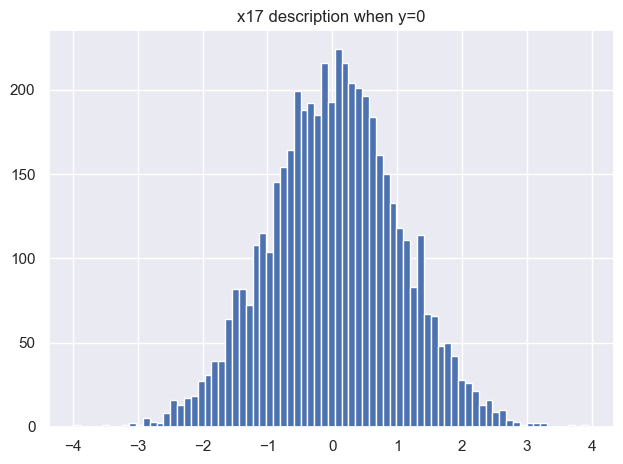

[-0.97331861  0.64499662  2.16715077 ...  0.53315249 -2.15056058
 -0.12738611]
count    4995.000000
mean        0.017453
std         0.986548
min        -3.508074
25%        -0.653298
50%         0.021277
75%         0.678842
max         3.797440
Name: x18, dtype: float64


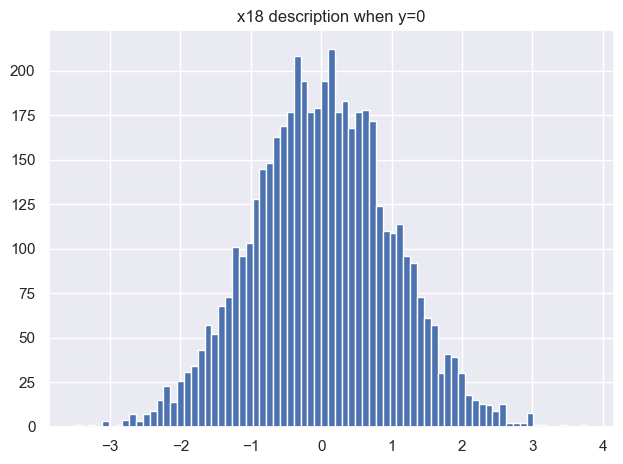

[-0.59197644 -2.16173162 -0.8153488  ... -0.14157636 -0.94911104
 -0.46217687]
count    4997.000000
mean       -0.010863
std         0.986398
min        -3.958827
25%        -0.669918
50%        -0.027549
75%         0.672737
max         4.093429
Name: x19, dtype: float64


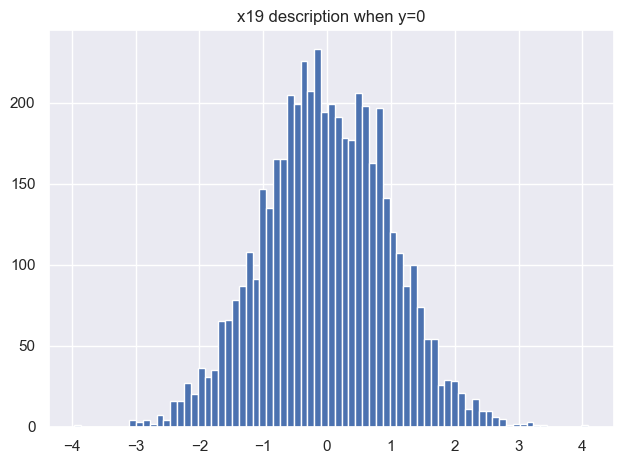

[-0.49169984  1.07510426  1.21715832 ...  0.47810115 -0.71665115
 -1.31169896]
count    4997.000000
mean        0.006801
std         1.351276
min        -4.247362
25%        -0.998095
50%         0.012478
75%         1.023335
max         3.757005
Name: x20, dtype: float64


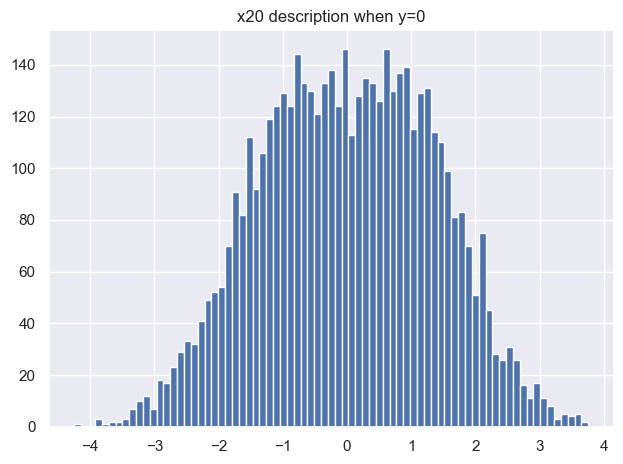

[ 0.29982979 -0.70987666  0.33719979 ...  0.10020838  0.43153942
 -0.5497023 ]
count    4997.000000
mean        0.003287
std         0.993324
min        -3.942723
25%        -0.680769
50%        -0.000477
75%         0.687545
max         3.563483
Name: x21, dtype: float64


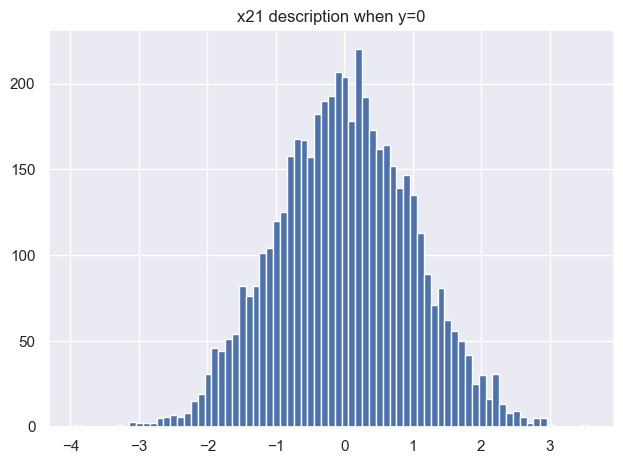

[ 0.5375868   0.93290792  0.15261207 ... -0.49773375 -0.75920136
  0.07106949]
count    4996.000000
mean       -0.004106
std         0.991260
min        -3.395311
25%        -0.671377
50%         0.013315
75%         0.663585
max         3.231857
Name: x22, dtype: float64


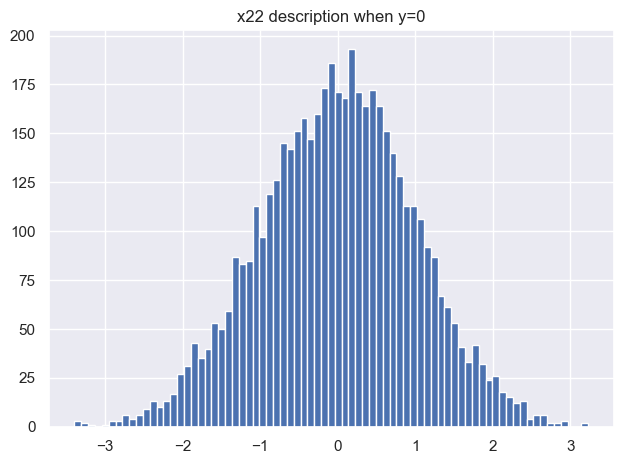

[ 0.16407272  0.17281239 -0.45960205 ...  1.56935276 -0.97861113
 -0.28255895]
count    4993.000000
mean        0.003568
std         1.009261
min        -3.828373
25%        -0.694142
50%         0.019466
75%         0.674683
max         4.005024
Name: x23, dtype: float64


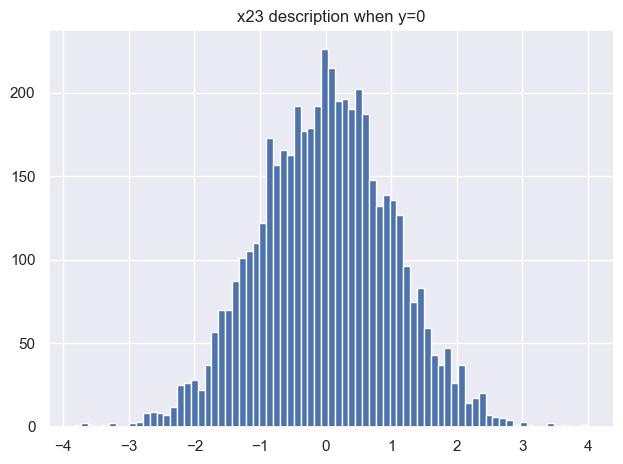

[-1.18782713 -0.94252996  0.77544218 ...  0.25927921  0.27253777
 -0.77561343]
count    4996.000000
mean        0.005464
std         1.010630
min        -3.535511
25%        -0.680413
50%         0.028624
75%         0.674651
max         4.021072
Name: x24, dtype: float64


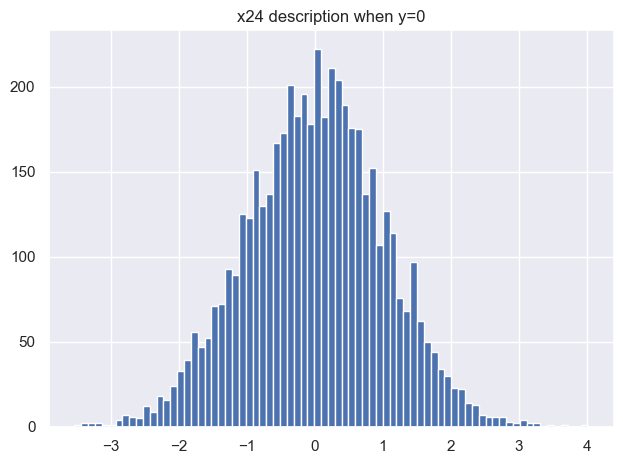

[-0.925975   -0.97926384  0.42532308 ... -0.2943005  -1.0988
 -1.96783186]
count    4993.000000
mean       -0.008112
std         1.017595
min        -3.636935
25%        -0.695115
50%         0.000630
75%         0.695421
max         3.473354
Name: x25, dtype: float64


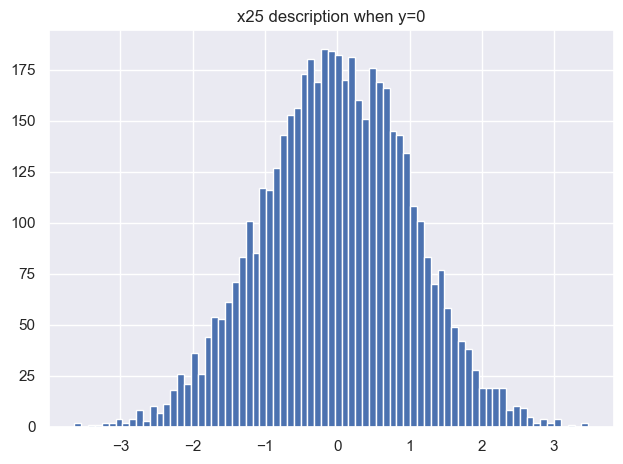

[ 0.11176631 -0.39618797 -0.50708151 ... -0.73289293 -1.611657
 -0.24281927]
count    4994.000000
mean        0.000630
std         1.014304
min        -4.001751
25%        -0.677398
50%        -0.002759
75%         0.691208
max         3.460170
Name: x26, dtype: float64


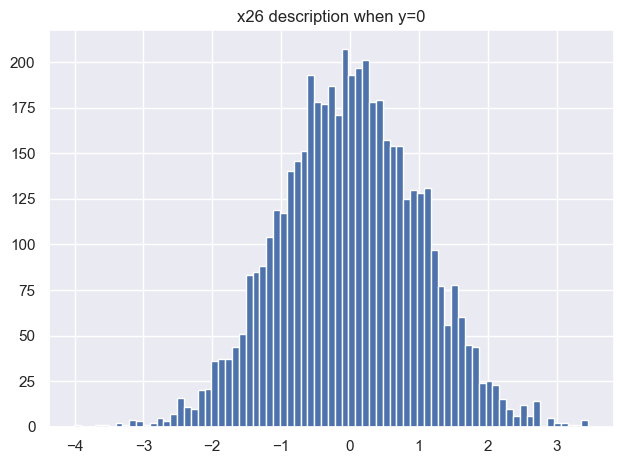

[ 0.30514955 -0.92526237 -0.43654815 ...  0.67262522  0.62009435
 -0.05132269]
count    4994.000000
mean        0.005603
std         1.004273
min        -3.739500
25%        -0.665257
50%        -0.005300
75%         0.684735
max         4.203944
Name: x27, dtype: float64


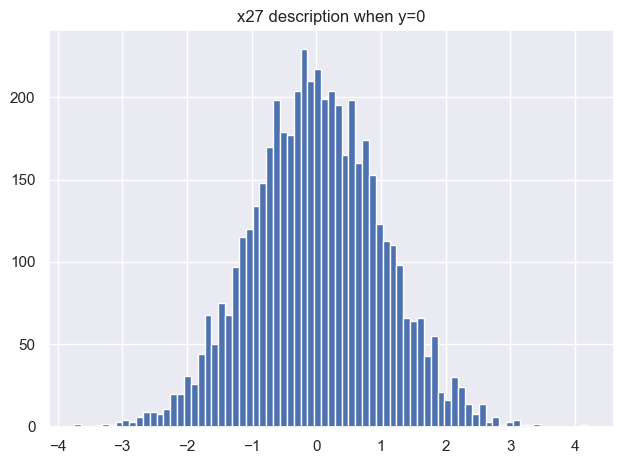

[-0.23646807  1.07535853  0.1380439  ... -1.36166518  2.19444865
  0.50860254]
count    4993.000000
mean       -0.026468
std         0.993965
min        -3.685236
25%        -0.704352
50%        -0.007113
75%         0.649505
max         3.387957
Name: x28, dtype: float64


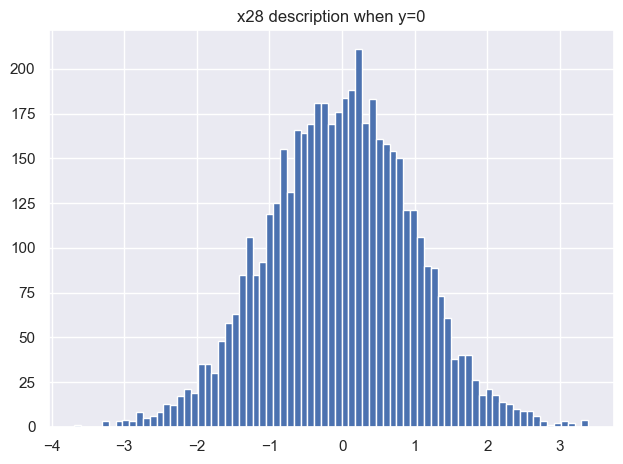

[ 0.60279089  0.84265282  1.46588506 ...  0.32955472 -2.32059003
  0.40356443]
count    4999.000000
mean        0.899788
std         1.439703
min        -5.430942
25%         0.109363
50%         0.663938
75%         1.470777
max         7.190733
Name: x29, dtype: float64


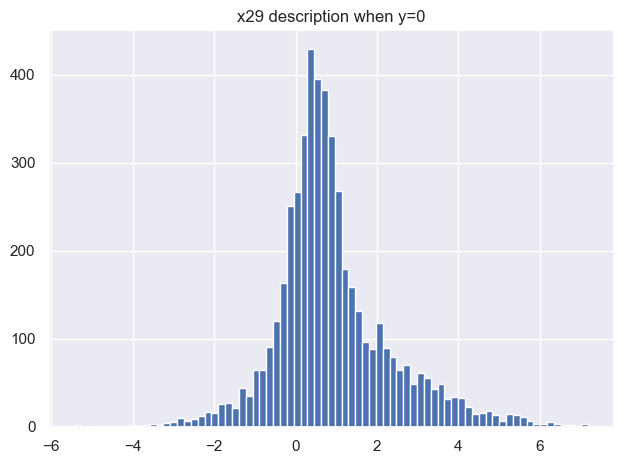

[ 0.25144098  0.49466306  0.60205279 ... -0.3260081   0.89884875
 -0.61297109]
count    4996.000000
mean        0.011674
std         0.988078
min        -3.444100
25%        -0.658019
50%         0.008678
75%         0.686285
max         3.958804
Name: x30, dtype: float64


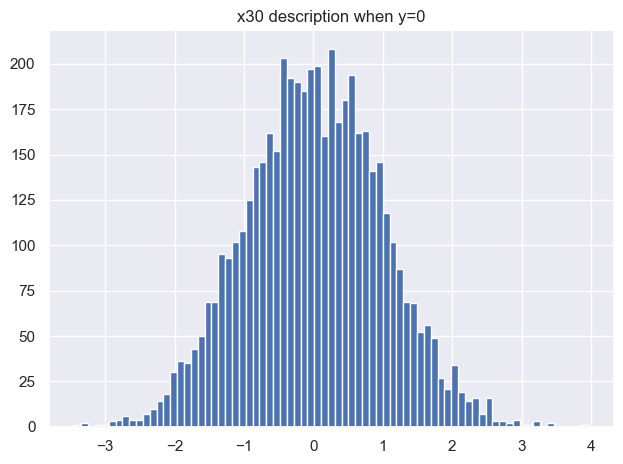

[ 0.12671826  0.37282089 -0.25741173 ... -2.24835468  0.26642694
 -1.49121487]
count    4994.000000
mean        0.003377
std         1.002221
min        -3.559078
25%        -0.658980
50%        -0.006934
75%         0.694042
max         3.855142
Name: x31, dtype: float64


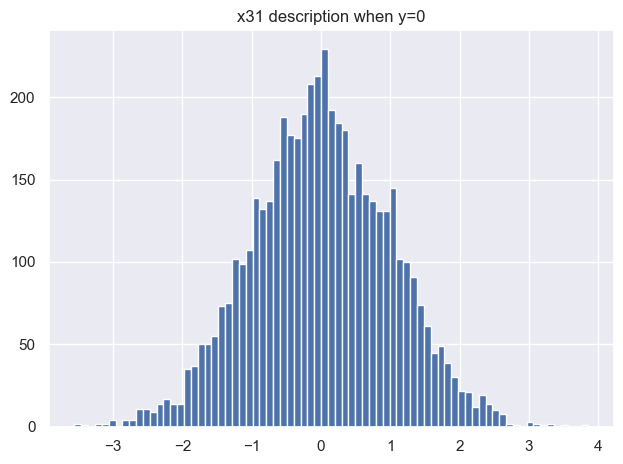

[-1.47861615  2.01970328 -1.63035284 ...  0.23208883 -0.75536196
 -0.31981295]
count    4997.000000
mean        0.008978
std         0.979380
min        -3.529604
25%        -0.657277
50%         0.014856
75%         0.658823
max         3.180252
Name: x32, dtype: float64


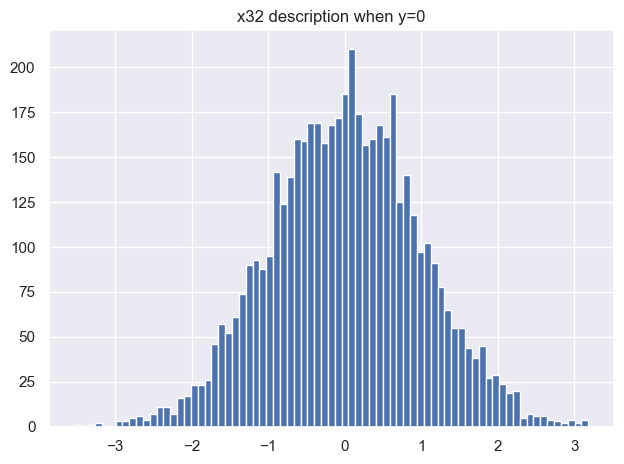

[-0.57393028  1.05918837  1.33175009 ...  0.63585915 -1.06053151
 -1.33918117]
count    4996.000000
mean       -0.000042
std         1.302021
min        -3.305432
25%        -1.016991
50%        -0.204070
75%         1.011859
max         4.189206
Name: x33, dtype: float64


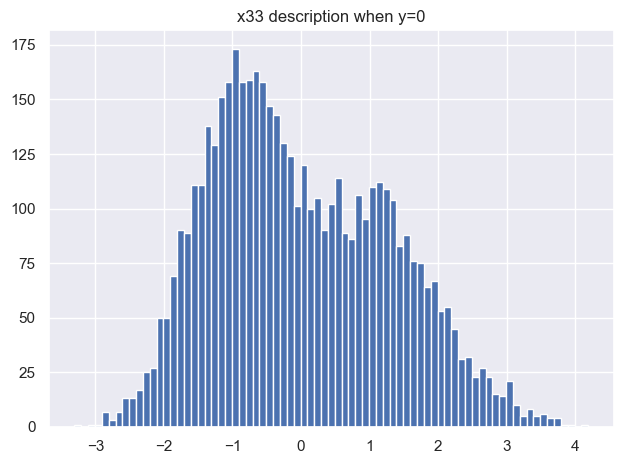

[-0.30077678  1.71066713 -0.74433762 ... -0.1623439   0.26759701
  1.33221756]
count    4999.000000
mean        0.005348
std         1.002711
min        -4.113791
25%        -0.671981
50%        -0.005062
75%         0.680868
max         4.712162
Name: x34, dtype: float64


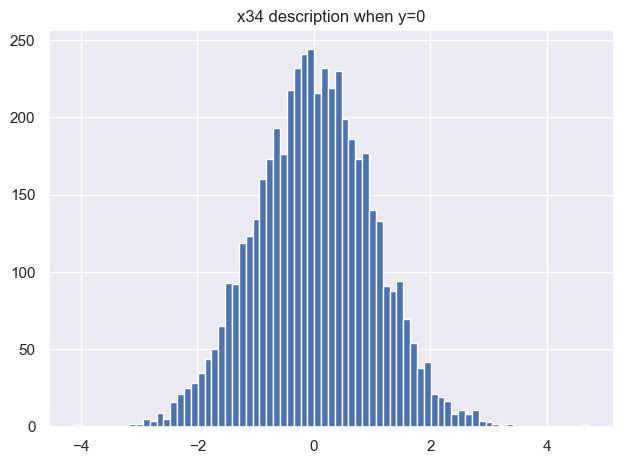

[-2.4895462  -0.39597094 -0.53640138 ...  1.33930432  1.00791992
  0.95340045]
count    4995.000000
mean        0.018574
std         0.990508
min        -3.621356
25%        -0.649762
50%         0.028065
75%         0.689806
max         3.550445
Name: x35, dtype: float64


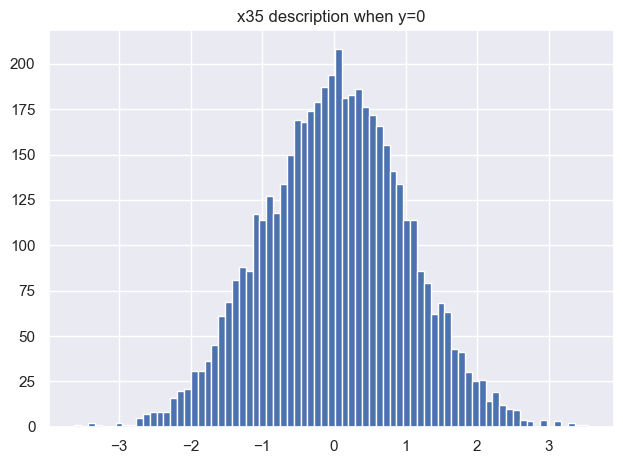

[ 1.10182586  0.5337675  -0.61975485 ... -0.5405676   1.62643736
 -0.69842284]
count    4994.000000
mean       -0.000422
std         0.998628
min        -3.610727
25%        -0.669754
50%         0.000956
75%         0.667659
max         3.670119
Name: x36, dtype: float64


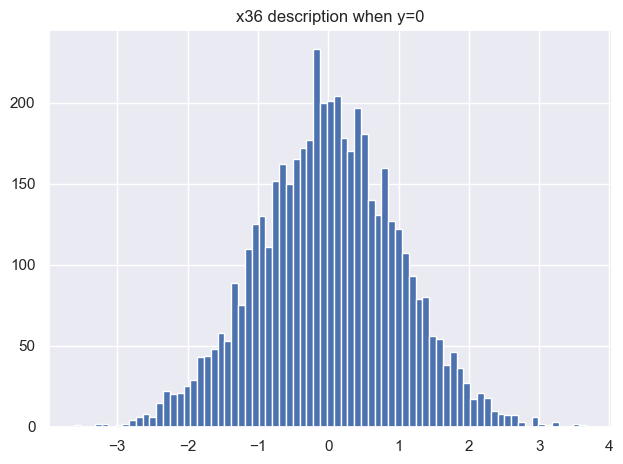

[-0.73689738 -1.24500285 -0.86770851 ... -0.81983216  0.17848019
  1.22756144]
count    4994.000000
mean        0.010089
std         1.001520
min        -4.259083
25%        -0.665763
50%         0.025387
75%         0.677842
max         3.353334
Name: x37, dtype: float64


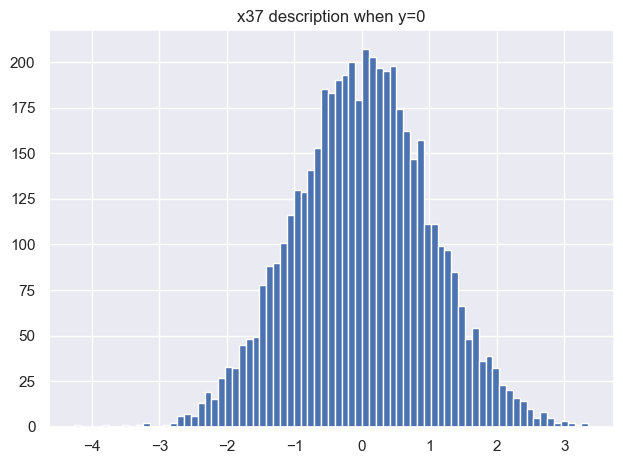

[ 1.109234    0.31581241 -0.84011814 ...  2.17035753 -1.53998297
  0.48050426]
count    4991.000000
mean       -0.005288
std         1.011248
min        -4.944162
25%        -0.713774
50%        -0.004303
75%         0.694860
max         3.745125
Name: x38, dtype: float64


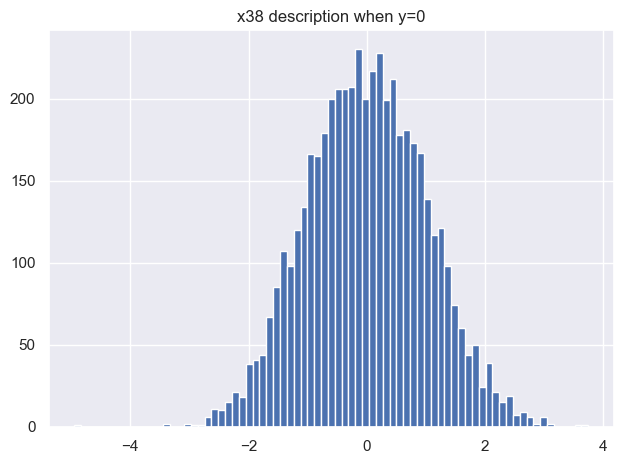

[ 0.41148822 -0.69660702  0.38846799 ...  0.71886119  2.21710466
 -0.02377067]
count    4996.000000
mean       -0.002239
std         1.002816
min        -3.868569
25%        -0.667104
50%        -0.017942
75%         0.660104
max         3.581667
Name: x39, dtype: float64


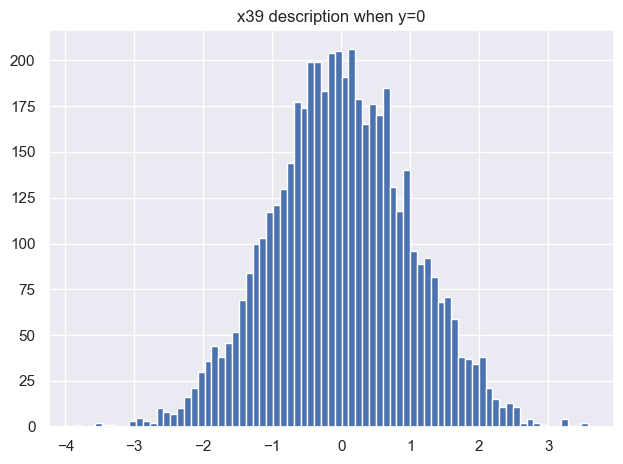

In [17]:
for var in float_vars:
    summarystats(data=df[df['y']==0], var=var, titleplot=f'{var} description when y=0', n_bins=75)

#### Run correlation plot

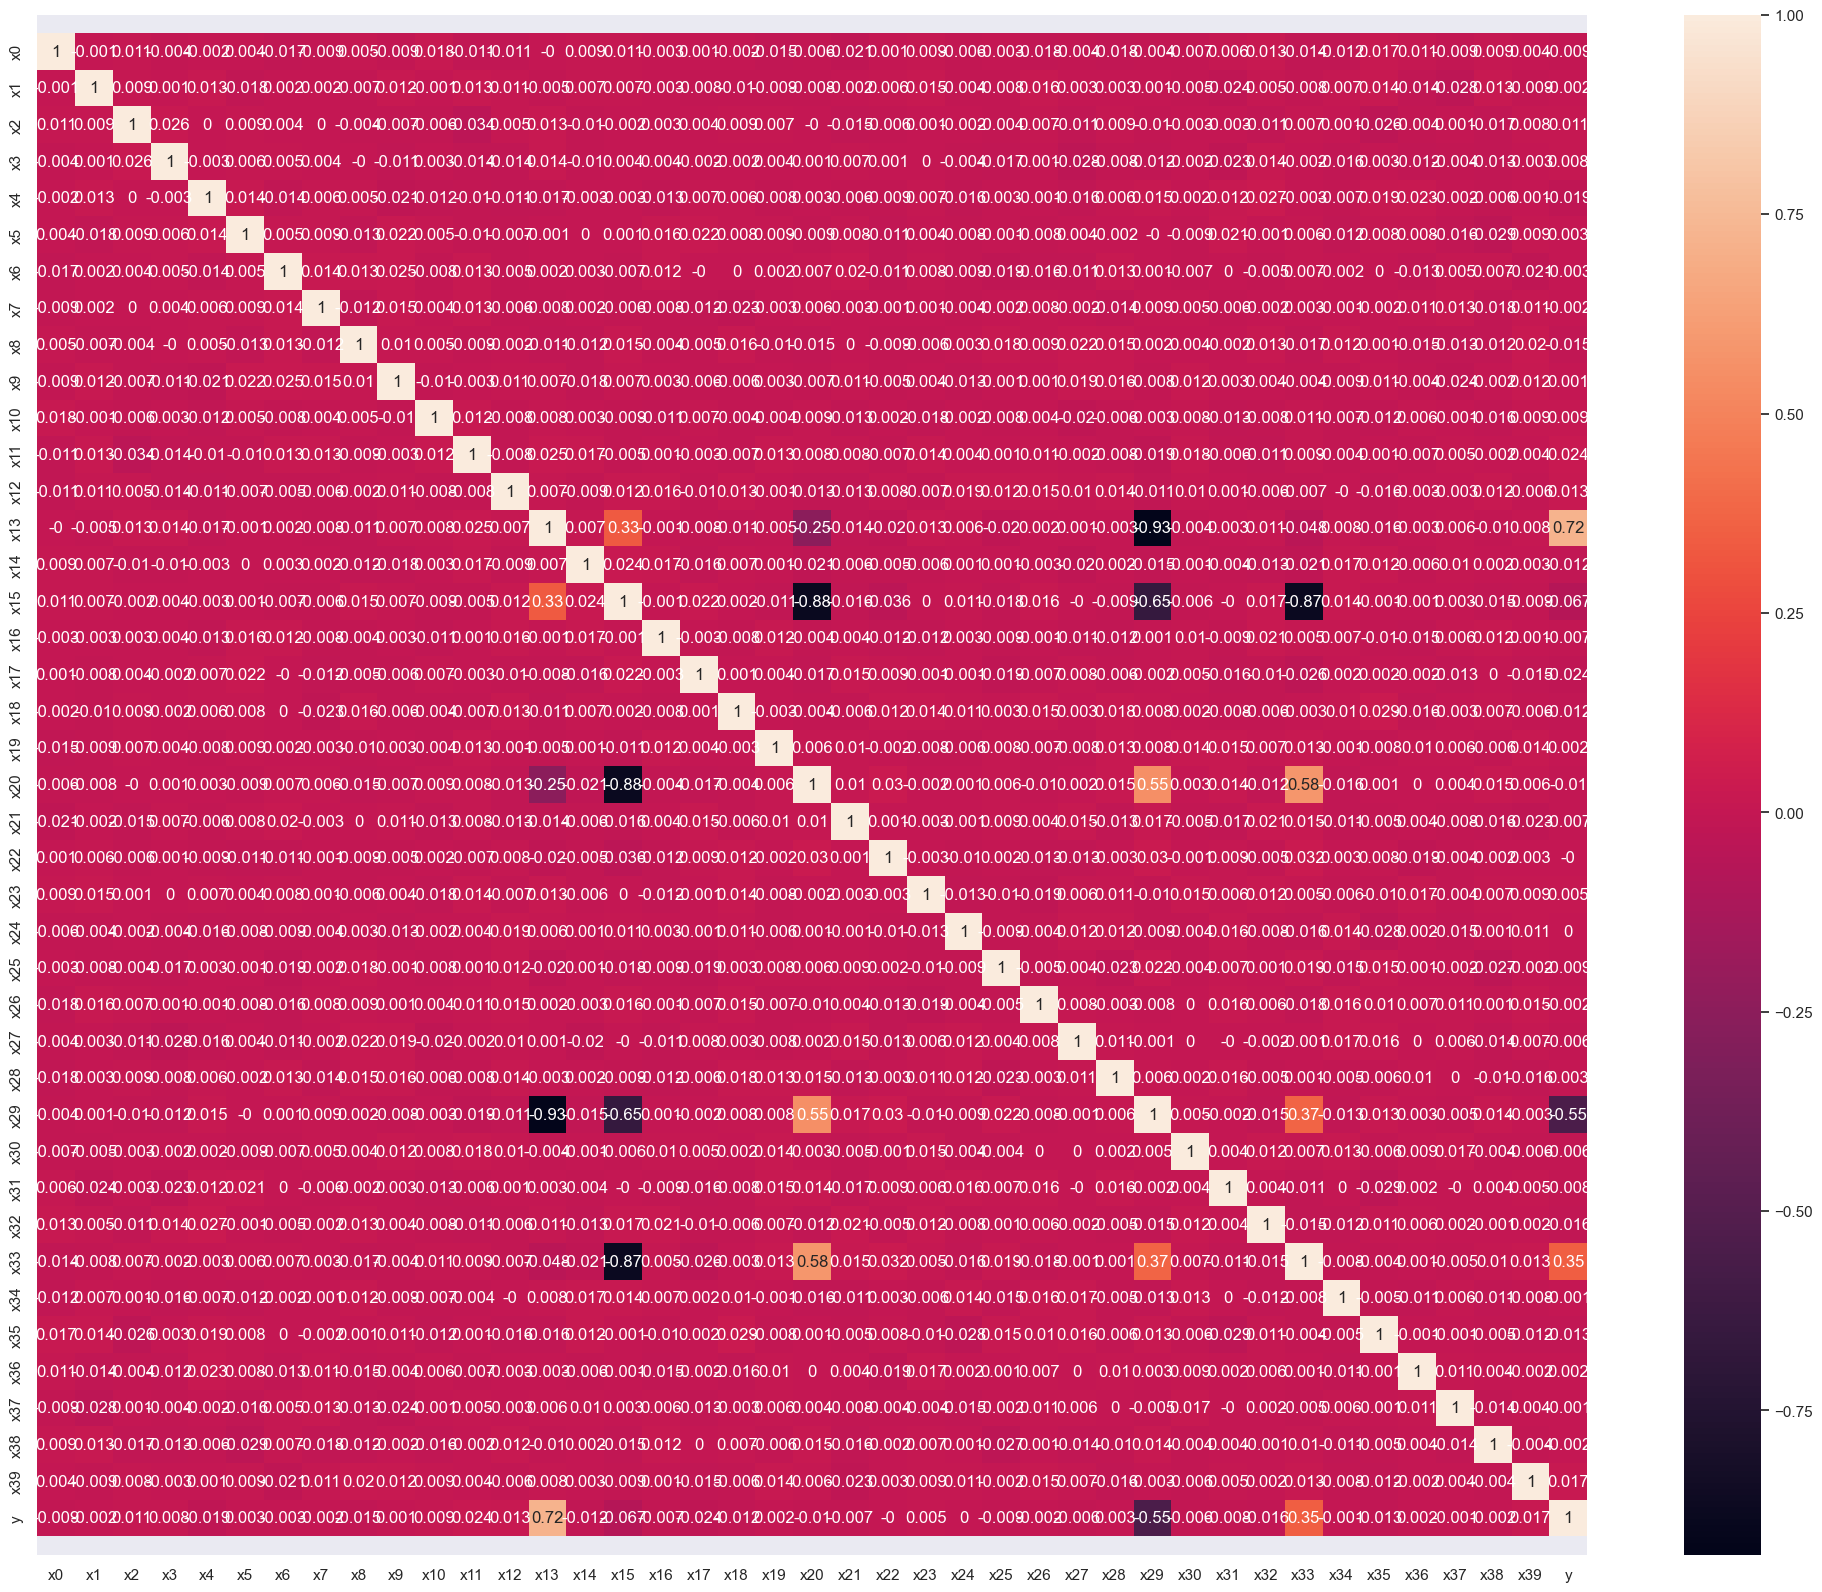

In [18]:
corrmap(data=df,figx=25, figy=20)

#### Examine mean value of the binary outcome variable for each feature

In [19]:
binary_means(data=df, feature_group='floats', y_col='y')

x0
y
0    0.003261
1   -0.013636
Name: x0, dtype: float64

x1
y
0   -0.003735
1   -0.007154
Name: x1, dtype: float64

x2
y
0   -0.026122
1   -0.003240
Name: x2, dtype: float64

x3
y
0   -0.012990
1    0.003738
Name: x3, dtype: float64

x4
y
0    0.037495
1   -0.000382
Name: x4, dtype: float64

x5
y
0   -0.003165
1    0.003778
Name: x5, dtype: float64

x6
y
0    0.003385
1   -0.002608
Name: x6, dtype: float64

x7
y
0   -0.002237
1   -0.007208
Name: x7, dtype: float64

x8
y
0    0.019924
1   -0.010549
Name: x8, dtype: float64

x9
y
0   -0.005721
1   -0.002883
Name: x9, dtype: float64

x10
y
0   -0.019582
1   -0.001741
Name: x10, dtype: float64

x11
y
0   -0.004114
1    0.044145
Name: x11, dtype: float64

x12
y
0   -0.007241
1    0.018057
Name: x12, dtype: float64

x13
y
0   -1.006459
1    1.005884
Name: x13, dtype: float64

x14
y
0    0.024697
1    0.000564
Name: x14, dtype: float64

x15
y
0   -0.161445
1   -0.328339
Name: x15, dtype: float64

x16
y
0    0.002502
1   -0.010678
Name: x16,

### DataProfiler approach

Use the [dataprofiler library](https://pypi.org/project/DataProfiler/) to assess the data.

In [20]:
data = Data("../data/raw_data.csv")

In [21]:
print(data.data.head(5)) # Access data directly via a compatible Pandas DataFrame

                    x0                   x1                    x2  \
0    1.563311563035811  -1.4174540464426892   -0.4902103243081357   
1  -1.9521785307544683   0.1270126110976403    1.5382984906051242   
2   0.9666990012655033  -0.4762763221687279   0.49171340746378883   
3  0.24578959868286923  0.21722568636880762   0.04432086830356444   
4  0.22460655823025186   0.5934784809041622  -0.06949806763334786   

                    x3                   x4                     x5  \
0  -1.5686891466862356   0.3674209492106672     0.0703034360979713   
1   0.3469055589707214   1.1884239149852853     0.8125832646319081   
2   1.7785206790481438  -0.9772428315939604    -0.4653066389498091   
3   0.7411321384556345    2.287138915465234  -0.013714808093077756   
4   -1.340076069809902   0.5730687323430599      0.926662645495074   

                    x6                    x7                    x8  \
0  -0.5350640011779543    0.1611538769188379   0.13025494058848153   
1  -0.9315592737757089  

In [22]:
profile = Profiler(data) # Calculate Statistics, Entity Recognition, etc

INFO:DataProfiler.profilers.profile_builder: Finding the Null values in the columns...  (with 9 processes)
INFO:DataProfiler.profilers.profile_builder: Processing Column 1/41
INFO:DataProfiler.profilers.profile_builder: Processing Column 2/41
INFO:DataProfiler.profilers.profile_builder: Processing Column 3/41
INFO:DataProfiler.profilers.profile_builder: Processing Column 4/41
INFO:DataProfiler.profilers.profile_builder: Processing Column 5/41
INFO:DataProfiler.profilers.profile_builder: Processing Column 6/41
INFO:DataProfiler.profilers.profile_builder: Processing Column 7/41
INFO:DataProfiler.profilers.profile_builder: Processing Column 8/41
INFO:DataProfiler.profilers.profile_builder: Processing Column 9/41
INFO:DataProfiler.profilers.profile_builder: Processing Column 10/41
INFO:DataProfiler.profilers.profile_builder: Processing Column 11/41
INFO:DataProfiler.profilers.profile_builder: Processing Column 12/41
INFO:DataProfiler.profilers.profile_builder: Processing Column 13/41
INFO:

Create a readable report

In [23]:
readable_report = profile.report(report_options={"output_format": "compact"})

In [24]:
readable_report

{'global_stats': {'samples_used': 5000,
  'column_count': 41,
  'row_count': 10000,
  'row_has_null_ratio': 0.0394,
  'row_is_null_ratio': 0.0,
  'unique_row_ratio': 1.0,
  'duplicate_row_count': 0,
  'file_type': 'csv',
  'encoding': 'utf-8',
  'correlation_matrix': None,
  'chi2_matrix': '[[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,\n  nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,\n  nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], ... , [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,\n  nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,\n  nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,  1.]]',
  'profile_schema': {'x0': [0],
   'x1': [1],
   'x2': [2],
   'x3': [3],
   'x4': [4],
   'x5': [5],
   'x6': [6],
   'x7': [7],
   'x8': [8],
   'x9': [9],
   'x10': [10],
   'x11': [11],
   'x12': [12],
   'x13': [13],
   'x14': [14],
   'x15': [15],
   'x16': [16],
   